## **Import các module**



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Optional, Union
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.feature_selection import VarianceThreshold
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## **Các hàm plot hay dùng**

In [ ]:
def evaluate_classification_model(model, X_train, y_train, X_test, y_test,
                                 model_name="Model", class_names=None, feature_names=None):
    """
    Hàm đánh giá mô hình classification đầy đủ

    Parameters:
    - model: mô hình đã được huấn luyện
    - X_train, y_train: dữ liệu huấn luyện
    - X_test, y_test: dữ liệu kiểm tra
    - model_name: tên mô hình (để hiển thị)
    - class_names: tên các lớp (nếu có)
    - feature_names: tên các đặc trưng/cột (nếu có)
    """

    # Dự đoán
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Dự đoán xác suất (cho ROC và PR curve)
    if hasattr(model, "predict_proba"):
        y_proba_test = model.predict_proba(X_test)[:, 1]  # Lớp dương
    else:
        y_proba_test = model.decision_function(X_test)
        y_proba_test = (y_proba_test - y_proba_test.min()) / (y_proba_test.max() - y_proba_test.min())  # Chuẩn hóa

    # Tính các metric
    metrics = {
        'Train Accuracy': accuracy_score(y_train, y_pred_train),
        'Test Accuracy': accuracy_score(y_test, y_pred_test),
        'Test Precision': precision_score(y_test, y_pred_test, average='weighted'),
        'Test Recall': recall_score(y_test, y_pred_test, average='weighted'),
        'Test F1-Score': f1_score(y_test, y_pred_test, average='weighted'),
        'Test ROC-AUC': roc_auc_score(y_test, y_proba_test)
    }

    print(f"=== Đánh giá mô hình {model_name} ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Classification Report
    print(f"\nClassification Report (Test):")
    print(classification_report(y_test, y_pred_test, target_names=class_names))

    # Vẽ các biểu đồ
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=class_names, yticklabels=class_names)
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    auc_score = roc_auc_score(y_test, y_proba_test)
    axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend()

    # 3. Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba_test)
    axes[1, 0].plot(recall_vals, precision_vals, label='Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].legend()

    # 4. Feature Importance (nếu có)
    if hasattr(model, 'coef_'):
        feature_importance = np.abs(model.coef_[0])
        top_features_idx = np.argsort(feature_importance)[-10:]  # 10 đặc trưng quan trọng nhất
        top_importance = feature_importance[top_features_idx]

        # Lấy tên đặc trưng
        if feature_names is not None:
            feature_labels = [feature_names[i] for i in top_features_idx]
        else:
            feature_labels = [f'Feature_{i}' for i in top_features_idx]

        axes[1, 1].barh(range(len(top_importance)), top_importance)
        axes[1, 1].set_yticks(range(len(top_importance)))
        axes[1, 1].set_yticklabels(feature_labels)
        axes[1, 1].set_title('Top 10 Feature Importance (Coefficients)')
        axes[1, 1].set_xlabel('Importance')

    elif hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        top_features_idx = np.argsort(feature_importance)[-10:]
        top_importance = feature_importance[top_features_idx]

        # Lấy tên đặc trưng
        if feature_names is not None:
            feature_labels = [feature_names[i] for i in top_features_idx]
        else:
            feature_labels = [f'Feature_{i}' for i in top_features_idx]

        axes[1, 1].barh(range(len(top_importance)), top_importance)
        axes[1, 1].set_yticks(range(len(top_importance)))
        axes[1, 1].set_yticklabels(feature_labels)
        axes[1, 1].set_title('Top 10 Feature Importance')
        axes[1, 1].set_xlabel('Importance')

    else:
        axes[1, 1].text(0.5, 0.5, 'Feature Importance\nkhông khả dụng',
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Feature Importance')

    plt.tight_layout()
    plt.show()

    return metrics

In [ ]:
# --- 1. Functions for Categorical Data ---

def plot_count(
    df: pd.DataFrame,
    column: str,
    hue: Optional[str] = None,
    order: Optional[List[str]] = None,
    palette: str = 'viridis',
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None
) -> plt.Axes:
    """
    Vẽ biểu đồ cột đếm số lượng cho một cột phân loại.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        column (str): Tên cột cần vẽ.
        hue (str, optional): Tên cột để phân nhóm màu. Mặc định là None.
        order (list, optional): Thứ tự hiển thị các nhãn trên trục x. Mặc định là None.
        palette (str, optional): Bảng màu của seaborn. Mặc định là 'viridis'.
        ax (plt.Axes, optional): Trục để vẽ biểu đồ. Mặc định là None (tạo mới).
        title (str, optional): Tiêu đề tùy chỉnh cho biểu đồ.

    Returns:
        plt.Axes: Đối tượng trục của biểu đồ.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.countplot(data=df, x=column, hue=hue, order=order, palette=palette, ax=ax)

    if title:
        ax.set_title(title, fontsize=16, weight='bold')
    else:
        ax.set_title(f'Phân phối của {column}', fontsize=16, weight='bold')

    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Số lượng', fontsize=12)

    # Add percentage labels on top of bars
    total = len(df)
    if hue:
        # For grouped bar plots
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom')
    else:
        # For simple bar plots
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return ax

In [ ]:

# --- 2. Functions for Numerical Data ---

def plot_distribution(
    df: pd.DataFrame,
    column: str,
    hue: Optional[str] = None,
    kde: bool = True,
    bins: int = 'auto',
    palette: str = 'viridis',
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None
) -> plt.Axes:
    """
    Vẽ biểu đồ phân phối (histogram và KDE) cho một cột số.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        column (str): Tên cột cần vẽ.
        hue (str, optional): Tên cột để phân nhóm màu. Mặc định là None.
        kde (bool, optional): Có vẽ đường KDE (Kernel Density Estimate) hay không. Mặc định là True.
        bins (int or str, optional): Số lượng bins của histogram. Mặc định là 'auto'.
        palette (str, optional): Bảng màu của seaborn. Mặc định là 'viridis'.
        ax (plt.Axes, optional): Trục để vẽ biểu đồ. Mặc định là None (tạo mới).
        title (str, optional): Tiêu đề tùy chỉnh cho biểu đồ.

    Returns:
        plt.Axes: Đối tượng trục của biểu đồ.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.histplot(data=df, x=column, hue=hue, kde=kde, bins=bins, palette=palette, ax=ax)

    if title:
        ax.set_title(title, fontsize=16, weight='bold')
    else:
        ax.set_title(f'Phân phối của {column}', fontsize=16, weight='bold')

    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Tần suất', fontsize=12)
    plt.tight_layout()
    return ax


def plot_box(
    df: pd.DataFrame,
    x: Optional[str] = None,
    y: str = '',
    hue: Optional[str] = None,
    palette: str = 'viridis',
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None
) -> plt.Axes:
    """
    Vẽ biểu đồ hộp (box plot) để so sánh phân phối.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        x (str, optional): Tên cột phân loại trên trục x. Mặc định là None.
        y (str): Tên cột số trên trục y.
        hue (str, optional): Tên cột để phân nhóm màu. Mặc định là None.
        palette (str, optional): Bảng màu của seaborn. Mặc định là 'viridis'.
        ax (plt.Axes, optional): Trục để vẽ biểu đồ. Mặc định là None (tạo mới).
        title (str, optional): Tiêu đề tùy chỉnh cho biểu đồ.

    Returns:
        plt.Axes: Đối tượng trục của biểu đồ.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.boxplot(data=df, x=x, y=y, hue=hue, palette=palette, ax=ax)

    if title:
        ax.set_title(title, fontsize=16, weight='bold')
    else:
        title_y = f'Phân phối của {y}'
        if x:
            ax.set_title(f'{title_y} theo {x}', fontsize=16, weight='bold')
        else:
            ax.set_title(title_y, fontsize=16, weight='bold')

    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return ax


In [ ]:
# --- 3. Functions for Bivariate/Multivariate Analysis ---
def plot_stacked_bar(
    df: pd.DataFrame,
    x: str,
    hue: str,
    normalize: bool = True,
    palette: str = 'viridis',
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None
) -> plt.Axes:
    """
    Vẽ biểu đồ cột xếp chồng (stacked bar chart), thường dùng để xem tỷ lệ phần trăm.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        x (str): Tên cột phân loại trên trục x.
        hue (str): Tên cột phân loại để xếp chồng.
        normalize (bool, optional): Nếu True, biểu đồ sẽ hiển thị tỷ lệ phần trăm (tổng = 100%). Mặc định là True.
        palette (str, optional): Bảng màu của seaborn. Mặc định là 'viridis'.
        ax (plt.Axes, optional): Trục để vẽ biểu đồ. Mặc định là None (tạo mới).
        title (str, optional): Tiêu đề tùy chỉnh cho biểu đồ.

    Returns:
        plt.Axes: Đối tượng trục của biểu đồ.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Tạo bảng tổng hợp (crosstab)
    counts = pd.crosstab(df[x], df[hue])

    if normalize:
        # Chuyển đổi thành tỷ lệ phần trăm
        counts = counts.div(counts.sum(axis=1), axis=0) * 100

    # Vẽ biểu đồ cột xếp chồng
    counts.plot(kind='bar', stacked=True, colormap=palette, ax=ax)

    if title:
        ax.set_title(title, fontsize=16, weight='bold')
    else:
        ax.set_title(f'Tỷ lệ {hue} theo {x}', fontsize=16, weight='bold')

    ax.set_xlabel(x, fontsize=12)
    if normalize:
        ax.set_ylabel('Tỷ lệ (%)', fontsize=12)
    else:
        ax.set_ylabel('Số lượng', fontsize=12)

    ax.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return ax



In [ ]:

# --- 4. Function for Multiple Plots (Faceting) ---

def plot_by_category(
    df: pd.DataFrame,
    col: str,
    plot_func: callable,
    plot_kwargs: dict,
    wrap_cols: int = 3,
    figsize: tuple = (18, 12)
) -> plt.Figure:
    """
    Vẽ một loạt biểu đồ con, mỗi biểu đồ cho một giá trị duy nhất của một cột phân loại.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        col (str): Tên cột để phân nhóm và tạo các biểu đồ con.
        plot_func (callable): Hàm vẽ biểu đồ (ví dụ: sns.histplot, sns.boxplot).
        plot_kwargs (dict): Từ điển chứa các đối số cho hàm vẽ.
        wrap_cols (int, optional): Số cột để sắp xếp các biểu đồ con. Mặc định là 3.
        figsize (tuple, optional): Kích thước tổng thể của biểu đồ. Mặc định là (18, 12).

    Returns:
        plt.Figure: Đối tượng hình vẽ.
    """
    categories = df[col].unique()
    n_categories = len(categories)
    n_rows = (n_categories + wrap_cols - 1) // wrap_cols

    fig, axes = plt.subplots(n_rows, wrap_cols, figsize=figsize)
    axes = axes.flatten() # Làm phẳng mảng trục để dễ lặp

    for i, category in enumerate(categories):
        ax = axes[i]
        data_subset = df[df[col] == category]

        # Gọi hàm vẽ với dữ liệu con và trục hiện tại
        plot_func(data=data_subset, ax=ax, **plot_kwargs)
        ax.set_title(f'{col}: {category}', weight='bold')

    # Ẩn các trục thừa
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    return fig


## **Đọc file**

In [ ]:
# Đoạn này có thể sử dụng kagglehub, nhưng cá nhân tôi thích với những dữ liệu không lớn thì đẩy lên github và dùng
df = pd.read_csv("https://raw.githubusercontent.com/thethien8a/Churn-Prediction-Telco/refs/heads/main/data/raw_data/Telco.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## **EDA + Tiền xử lý dữ liệu cơ bản trên toàn bộ tập dữ liệu**

### **Giải thích bộ dữ liệu**
Bộ dữ liệu **Telco Customer Churn** từ IBM chứa thông tin chi tiết về khách hàng của một công ty viễn thông giả định. Mục tiêu chính là dự đoán khách hàng nào có khả năng sẽ rời bỏ dịch vụ (churn).

### **Ý nghĩa các cột dữ liệu**

Các cột được chia thành 4 nhóm chính: **Thông tin khách hàng**, **Dịch vụ đã đăng ký**, **Thông tin tài khoản**, và **Nhãn mục tiêu**.

#### 1. Thông tin khách hàng (Customer Information)

| Tên cột | Ý nghĩa | Kiểu dữ liệu | Ví dụ |
| :--- | :--- | :--- | :--- |
| `customerID` | Mã định danh duy nhất của mỗi khách hàng. | Chuỗi (String) | "7590-VHVEG" |
| `gender` | Giới tính của khách hàng. | Chuỗi (String) | "Female", "Male" |
| `SeniorCitizen` | Khách hàng có phải là người cao tuổi (65 tuổi trở lên) hay không. | Số nguyên (Integer) | 0 (Không), 1 (Có) |
| `Partner` | Khách hàng có có bạn đời hoặc người đồng hành không. | Chuỗi (String) | "Yes", "No" |
| `Dependents` | Khách hàng có người phụ thuộc (ví dụ: con cái) không. | Chuỗi (String) | "Yes", "No" |

#### 2. Dịch vụ đã đăng ký (Services Signed Up For)

| Tên cột | Ý nghĩa | Kiểu dữ liệu | Các giá trị |
| :--- | :--- | :--- | :--- |
| `PhoneService` | Khách hàng có đăng ký dịch vụ điện thoại không. | Chuỗi (String) | "Yes", "No" |
| `MultipleLines` | Khách hàng có đăng ký nhiều đường dây điện thoại không. | Chuỗi (String) | "Yes", "No", "No phone service" |
| `InternetService` | Nhà cung cấp dịch vụ Internet của khách hàng. | Chuỗi (String) | "DSL", "Fiber optic", "No" |
| `OnlineSecurity` | Khách hàng có đăng ký dịch vụ bảo mật trực tuyến không. | Chuỗi (String) | "Yes", "No", "No internet service" |
| `OnlineBackup` | Khách hàng có đăng ký dịch vụ sao lưu trực tuyến không. | Chuỗi (String) | "Yes", "No", "No internet service" |
| `DeviceProtection` | Khách hàng có đăng ký dịch vụ bảo vệ thiết bị không. | Chuỗi (String) | "Yes", "No", "No internet service" |
| `TechSupport` | Khách hàng có đăng ký dịch vụ hỗ trợ kỹ thuật không. | Chuỗi (String) | "Yes", "No", "No internet service" |
| `StreamingTV` | Khách hàng có đăng ký dịch vụ truyền hình trực tuyến không. | Chuỗi (String) | "Yes", "No", "No internet service" |
| `StreamingMovies` | Khách hàng có đăng ký dịch vụ xem phim trực tuyến không. | Chuỗi (String) | "Yes", "No", "No internet service" |

#### 3. Thông tin tài khoản (Account Information)

| Tên cột | Ý nghĩa | Kiểu dữ liệu | Ví dụ |
| :--- | :--- | :--- | :--- |
| `tenure` | Số tháng khách hàng đã gắn bó với công ty. | Số nguyên (Integer) | 1, 34, 2 |
| `Contract` | Loại hợp đồng của khách hàng. | Chuỗi (String) | "Month-to-month", "One year", "Two year" |
| `PaperlessBilling` | Khách hàng có sử dụng hóa đơn điện tử không. | Chuỗi (String) | "Yes", "No" |
| `PaymentMethod` | Phương thức thanh toán của khách hàng. | Chuỗi (String) | "Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)" |
| `MonthlyCharges` | Số tiền khách hàng phải trả hàng tháng. | Số thực (Float) | 29.85, 56.95, 53.85 |
| `TotalCharges` | Tổng số tiền khách hàng đã thanh toán đến nay. | Số thực (Float) | 29.85, 1889.50, 108.15 |

#### 4. Nhãn mục tiêu (Target Label)

| Tên cột | Ý nghĩa | Kiểu dữ liệu | Các giá trị |
| :--- | :--- | :--- | :--- |
| `Churn` | Khách hàng có rời bỏ công ty trong tháng cuối cùng hay không. | Chuỗi (String) | "Yes", "No" |

In [ ]:
# Số hàng và cột của bộ dữ liệu
df.shape

(7043, 21)

7043 hàng, 21 cột. Tập dữ liệu tương đối nhỏ

In [ ]:
# Xem 1 vài thông tin về dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Mặc dù ở đây non-null là 7043 tuy nhiên chưa thể khẳng định rằng không có cột nào bị thiếu vì kiểu dữ liệu object ở đây xuất hiện nhiều. Giá trị null có thể là khoảng trắng ("")

In [ ]:
# Xem mô tả các giá trị số
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Xem qua thì ta thấy:
- Khách hàng không phải cao tuổi chiếm nhiều hơn là cao tuổi (do mean gần với 0)
- Khách hàng gắn bó lâu nhất tính đến thời điểm hiện tại là 72 tháng (tương đương 6 năm). Chứng tỏ công ty này đã thành lập được khoảng >= 6 năm.
- Trung bình số tiền mỗi khách hàng đóng mỗi tháng là 64,76 (đơn vị có thể là $)

### Ở đây, ta đưa ra bài toán giả định

Đây là một công ty tương đối nhỏ (giả định sau 6 năm chỉ có khoảng hơn 7,000 khách hàng).

Theo nghiên cứu trong bài báo **"Customer Acquisition and Retention Spending: An Analytical Model and Empirical Investigation in Wireless Telecommunications Markets"** (Journal of Marketing Research, Vol 53 Issue 5, 2016), khi phân tích thị trường viễn thông không dây tại 41 quốc gia (1999-2007), các tác giả nhận thấy rằng:

> *"A firm's acquisition cost per customer is more sensitive … than retention cost per customer"*

**Nghĩa là:** Chi phí thu hút khách hàng mới cao hơn nhiều so với chi phí giữ chân khách hàng hiện tại trong ngành này. Điều này cho thấy tầm quan trọng của việc giữ chân khách hàng là rất cao.

**Do đó**, tôi quyết định sử dụng chỉ số **Recall** để đánh giá các mô hình vì:
- Recall tập trung vào việc đánh nhãn "Churn" cho tất cả những đối tượng được coi là khả nghi
- Đánh đổi theo đó là Precision có thể sẽ trung bình hoặc thấp, bởi việc bất cứ ai khả thi sẽ bị gán là "Churn" thì hiển nhiên việc đoán đúng người đó là Churn thật sẽ thấp hơn

In [ ]:
# Kiểm tra xem có customerID nào bị lặp lại không
print("Số CustomerID bị lặp lại:",df["customerID"].duplicated().sum())


Số CustomerID bị lặp lại: 0


### Xem tỷ lệ các giá trị churn:

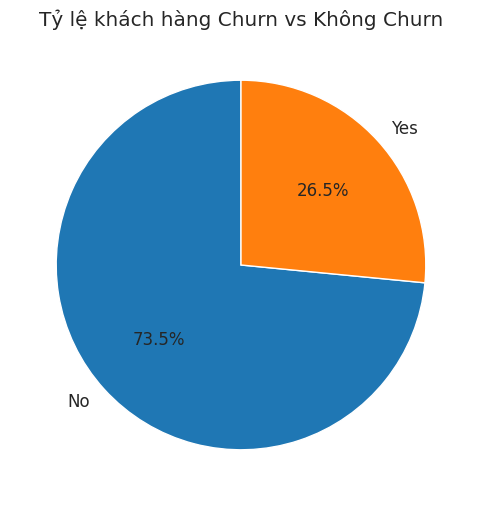

In [ ]:
# Tính tỷ lệ phần trăm
churn_counts = df["Churn"].value_counts(normalize=True)

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(
    churn_counts,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    # colors=['lightgreen', 'lightcoral']
)
plt.title("Tỷ lệ khách hàng Churn vs Không Churn")
plt.show()

-> Không thể dùng accuracy do tập dữ liệu này mất cân bằng, độ chính xác sẽ rất cao, nói đơn giản:

Giả sử rằng khách hàng nào bạn cũng đoán là "No Churn" thì Accuracy của bạn là 73,6%. Nghe có vẻ lớn nhưng thực chất bạn chả đoán được ai là "Churn" cả.

Trong trường hợp này chúng ta sẽ sử dụng các chỉ số khác như: Precision, Recall, F1-Score hay AUC-ROC

### Tiền xử lý cơ bản trên toàn bộ tập dữ liệu:

In [ ]:
# Đổi tên "Churn" thành "IsChurn" và giá trị "Yes"/"No" thành 1/0
df["IsChurn"] = df["Churn"].map({"Yes": 1, "No": 0})
df.drop(columns=["Churn"], inplace=True)

In [ ]:
# Xóa customerID bị lặp (nếu có)
df.drop_duplicates(subset="customerID", inplace=True)

In [ ]:
# Loại bỏ cột "CustomerID" vì nó chỉ là khóa xác định cho từng thực thể, không mang ý nghĩa kinh doanh
df.drop(columns=["customerID"], inplace=True)

In [ ]:
# Loại bỏ các giá trị bị trùng lặp (nếu có)
df.drop_duplicates(inplace=True)

In [ ]:
print("Số hàng và cột còn lại:",df.shape)

Số hàng và cột còn lại: (7021, 20)


Ta nhận thấy sau khi tiền xử lý đơn giản thì số hàng giảm đi từ 7043 xuống còn 7021

In [ ]:
# Làm sạch các khoảng trắng thừa ở các biến chữ nếu có
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [ ]:
object_columns = df.select_dtypes("object").columns

### Tiền xử lý null ở cột chữ (nếu có thể mà không gây ra data leakage):

In [ ]:
# Ta check các giá trị NULL
print(f"{'Column':<25} {'Empty Count':>12}")
print("-" * 38)
for col in object_columns:
    empty_count = len(df[df[col] == ''])
    print(f"{col:<25} {empty_count:>12,}")

Column                     Empty Count
--------------------------------------
gender                               0
Partner                              0
Dependents                           0
PhoneService                         0
MultipleLines                        0
InternetService                      0
OnlineSecurity                       0
OnlineBackup                         0
DeviceProtection                     0
TechSupport                          0
StreamingTV                          0
StreamingMovies                      0
Contract                             0
PaperlessBilling                     0
PaymentMethod                        0
TotalCharges                        11


Ta thấy tồn tại cột "TotalCharges" có chứa 11 giá trị trống. Ta cùng tìm hiểu cột này trước tiên

In [ ]:
print(df["TotalCharges"].head())

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object


Nhẽ ra cột này phải là kiểu giá trị float nhưng có lẽ vài cột trống nên khiến nó phải là kiểu dữ liệu object

In [ ]:
# Ta quan sát lại 2 cột số "tenture" và "MonthlyCharges", kết hợp và 1 cột ta tạo tên: ProductTenureMonthcharge là tích của 2 cột "ten ..." và "Monthly ..."
temp = df[["tenure","MonthlyCharges", "TotalCharges"]].copy()
temp["ProductTenureMonthcharge"] = temp["tenure"] * temp["MonthlyCharges"]

In [ ]:
temp.head(10)

,tenure,MonthlyCharges,TotalCharges,ProductTenureMonthcharge
0,1,29.85,29.85,29.85
1,34,56.95,1889.5,1936.30
2,2,53.85,108.15,107.70
3,45,42.30,1840.75,1903.50
4,2,70.70,151.65,141.40
5,8,99.65,820.5,797.20
6,22,89.10,1949.4,1960.20
7,10,29.75,301.9,297.50
8,28,104.80,3046.05,2934.40
9,62,56.15,3487.95,3481.30


Để ý thấy rằng 2 cột TotalCharges và ProductTenureMonthcharge có giá trị tương đối gần giống nhau.  

**Tôi đặt giả thuyết** ở đây đó chính là: **TotalCharges = tenure * MonthlyCharges * Something** với **Something** là tỷ lệ phần trăm hoặc gì đó thay đổi theo thời gian (kiểu khách hàng gắn bó càng lâu thì số tiền hàng tháng sẽ được giảm chẳng hạn)

In [ ]:
# Vốn dĩ tôi có giả định trên bởi vì:
# Ta quan sát với tenure bằng 1, sẽ thấy TotalCharges và ProductTenureMonthcharge là bằng nhau
temp[temp["tenure"] == 1].head(10)

,tenure,MonthlyCharges,TotalCharges,ProductTenureMonthcharge
0,1,29.85,29.85,29.85
20,1,39.65,39.65,39.65
22,1,20.15,20.15,20.15
27,1,30.20,30.2,30.20
33,1,20.20,20.2,20.20
34,1,45.25,45.25,45.25
70,1,49.05,49.05,49.05
80,1,79.35,79.35,79.35
91,1,74.70,74.7,74.70
100,1,20.20,20.2,20.20


In [ ]:
# Nhưng khi tenure > 1, kết quả lúc này sẽ khác
temp[temp["tenure"] > 1].head(10)

,tenure,MonthlyCharges,TotalCharges,ProductTenureMonthcharge
1,34,56.95,1889.5,1936.30
2,2,53.85,108.15,107.70
3,45,42.30,1840.75,1903.50
4,2,70.70,151.65,141.40
5,8,99.65,820.5,797.20
6,22,89.10,1949.4,1960.20
7,10,29.75,301.9,297.50
8,28,104.80,3046.05,2934.40
9,62,56.15,3487.95,3481.30
10,13,49.95,587.45,649.35


Những điều ở trên phần nào đã củng cố giả thuyết của tôi   
Do đó, tôi sẽ dùng ProductTenureMonthcharge để xấp xỉ cho TotalCharges với những giá trị thiếu

In [ ]:
temp["TotalCharges"] = temp["TotalCharges"].replace("", np.nan).astype(float)
temp["TotalCharges"] = temp["TotalCharges"].fillna(temp["ProductTenureMonthcharge"])
df["TotalCharges"] = temp["TotalCharges"]

## **EDA trên tập train**

### Chia train, test cho df

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["IsChurn"])

In [ ]:
df_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn
2629,Male,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Credit card (automatic),70.70,140.70,1
2650,Female,0,No,No,15,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),84.35,1302.65,0
1418,Male,0,Yes,Yes,67,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),89.55,6373.10,0
5774,Male,0,No,No,5,Yes,No,DSL,No,Yes,No,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),65.60,339.90,0
2425,Male,0,No,No,26,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,20.30,511.25,0


Để hỗ trợ cho việc EDA, tôi sẽ biến đổi các cột chữ tạm thời thành biến số để hỗ trợ cho việc xác định xem đâu là những biến có quan hệ tuyến tính mạnh đối với churn. Vốn dĩ tôi chọn việc Label Encode vì các biến chữ đa phần là low cardinality nên việc dùng label encode là hợp lý.

In [ ]:
label = LabelEncoder()
categorical_cols = df_train.select_dtypes(include=['object']).columns
df_train_encoded = df_train.copy()
for col in categorical_cols:
    if col != "customerID":
        df_train_encoded[col] = label.fit_transform(df_train[col].astype(str))

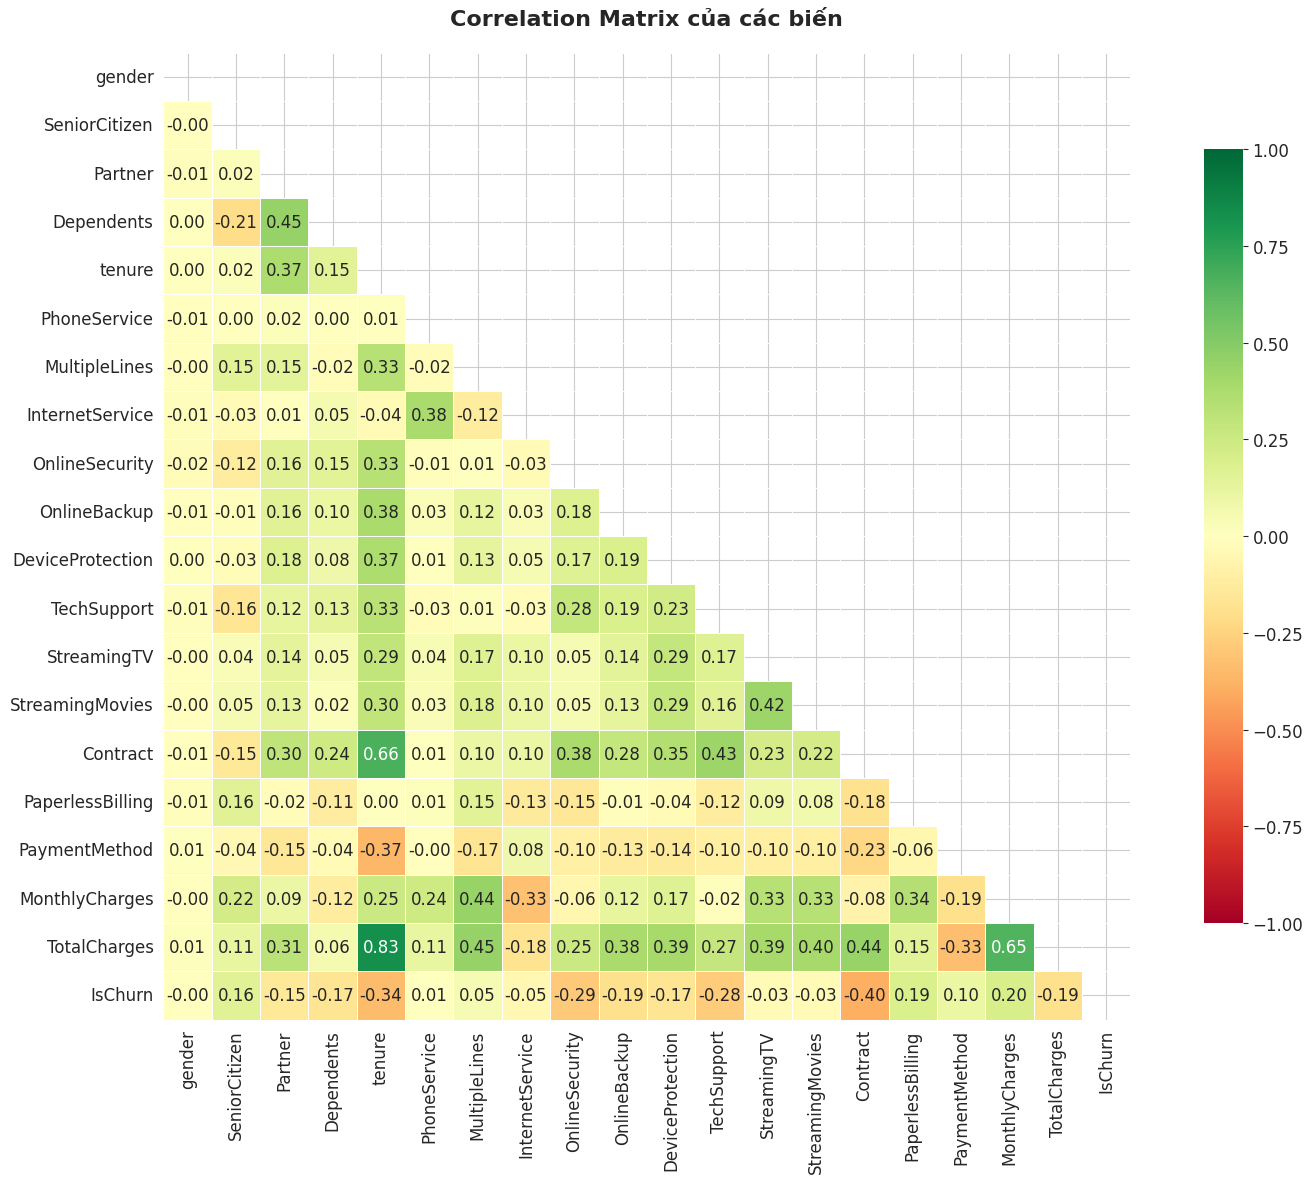

In [ ]:
# Kiểm tra đa cộng tuyến (trong trường hợp sử dụng các mô hình tuyến tính ta cần tránh vấn đề này xảy ra)
# Tính correlation matrix
corr_matrix = df_train_encoded.corr()

# Vẽ heatmap đẹp với seaborn
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask phần trên để chỉ hiển thị tam giác dưới
sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='RdYlGn',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix của các biến', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

- Có đa cộng tuyến mạnh xảy ra giữa tenure và TotalCharges, cả MonthlyCharges với TotalCharges nữa.
- Cột tenure gây đa cộng tuyến (từ trung bình đến mạnh) với khá nhiều cột

Đề xuất loại bỏ tenure và MonthlyCharges nếu sử dụng các mô hình tuyến tính như SVM và Logistic Regression

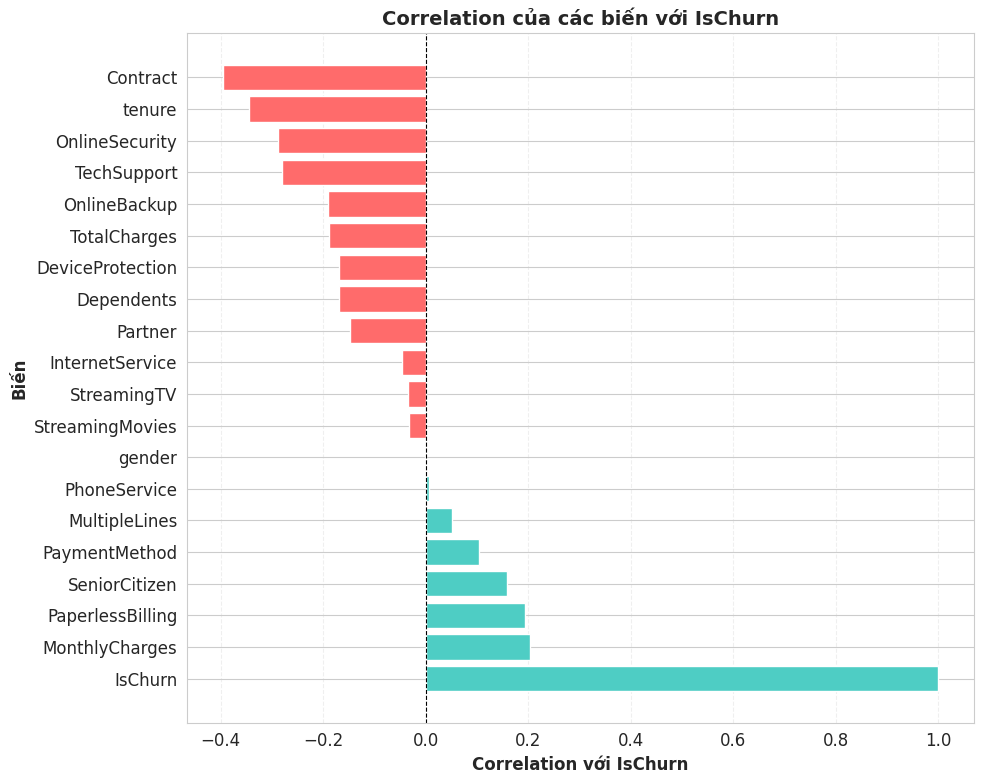

In [ ]:
# Tính correlation của các biến đầu vào với target IsChurn
correlation = df_train_encoded.corr()["IsChurn"].sort_values(ascending=False)

# Plot correlation với màu sắc đẹp
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in correlation.values]
bars = plt.barh(range(len(correlation)), correlation.values, color=colors)
plt.yticks(range(len(correlation)), correlation.index)
plt.xlabel('Correlation với IsChurn', fontsize=12, fontweight='bold')
plt.ylabel('Biến', fontsize=12, fontweight='bold')
plt.title('Correlation của các biến với IsChurn', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
# Lấy ra những cột có có corr >= 0.2
high_corr_features = correlation[correlation.abs() >= 0.2].sort_values(ascending=False).index.tolist()
high_corr_features.remove('IsChurn')  # Loại bỏ target variable
print("Các biến có correlation > 0.2 với IsChurn:")
print(high_corr_features)

Các biến có correlation > 0.2 với IsChurn:
['MonthlyCharges', 'TechSupport', 'OnlineSecurity', 'tenure', 'Contract']


Ta sẽ tập trung vào những cột: 'MonthlyCharges', 'TechSupport', 'OnlineSecurity', 'tenure', 'Contract' trước

#### Contract

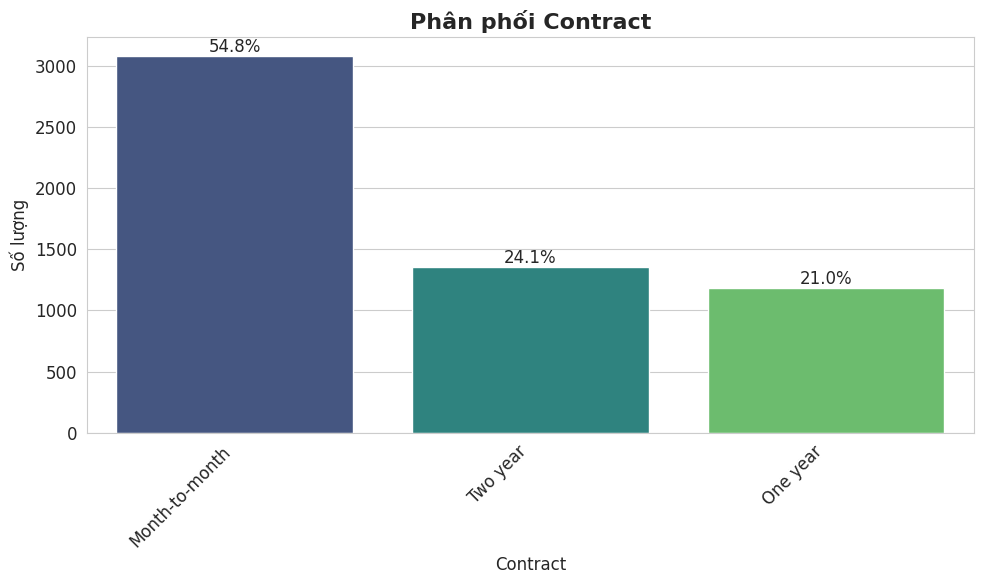

In [ ]:
plot_count(df_train, column="Contract", title="Phân phối Contract");

Đa phần khách hàng chúng ta là Month-to-month

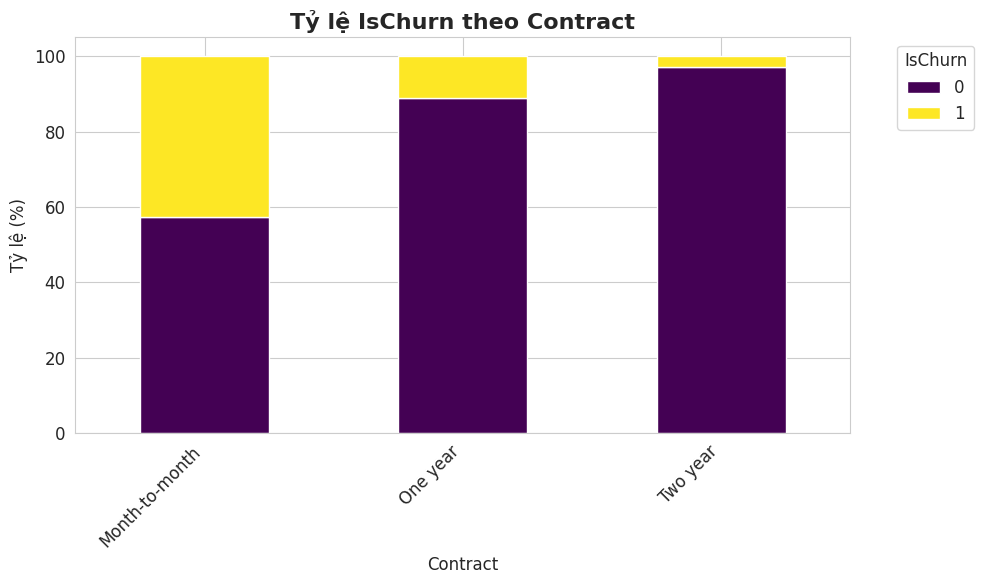

In [ ]:
plot_stacked_bar(df_train, x="Contract", hue="IsChurn");

**Insight**: Cột Month-to-month có tỷ lệ khách hàng rời đi là cao nhất. Với hợp đồng càng dài hạn thì tỷ lệ Churn càng thấp đi. Điều này không phải vấn đề do số lượng mẫu thấp ở one year và two year bởi tỷ lệ mẫu của one year chiếm gần 1/4 (giống với tỷ lệ mẫu của two year)

**Hàm ý hành động**: Thiết kế chiến dịch upsell sang gói dài hạn, đồng thời phân tích lý do khách chọn Month-to-month (giá, ràng buộc, loại dịch vụ kèm theo) để giảm rào cản.

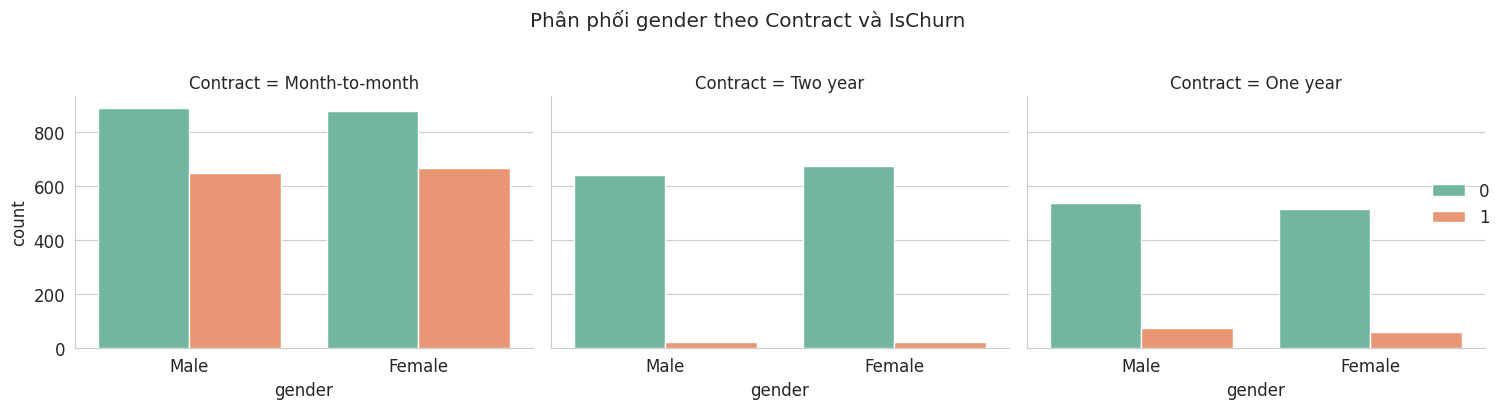

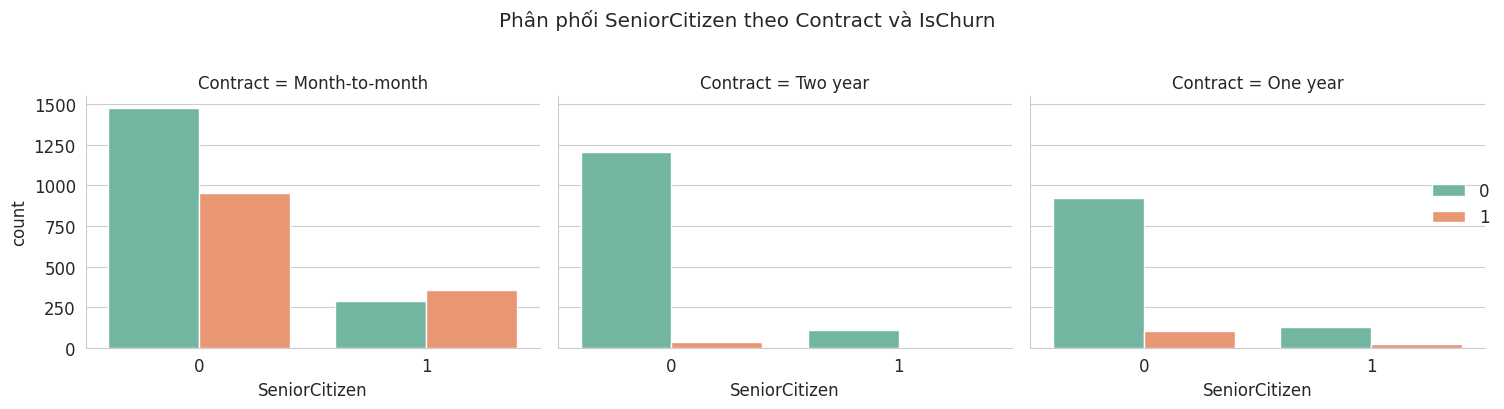

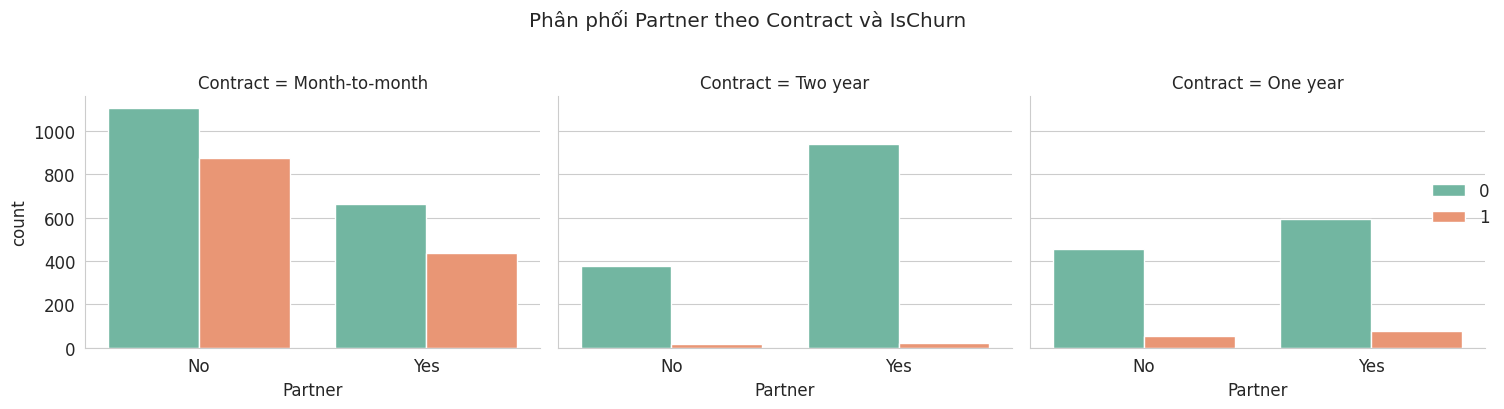

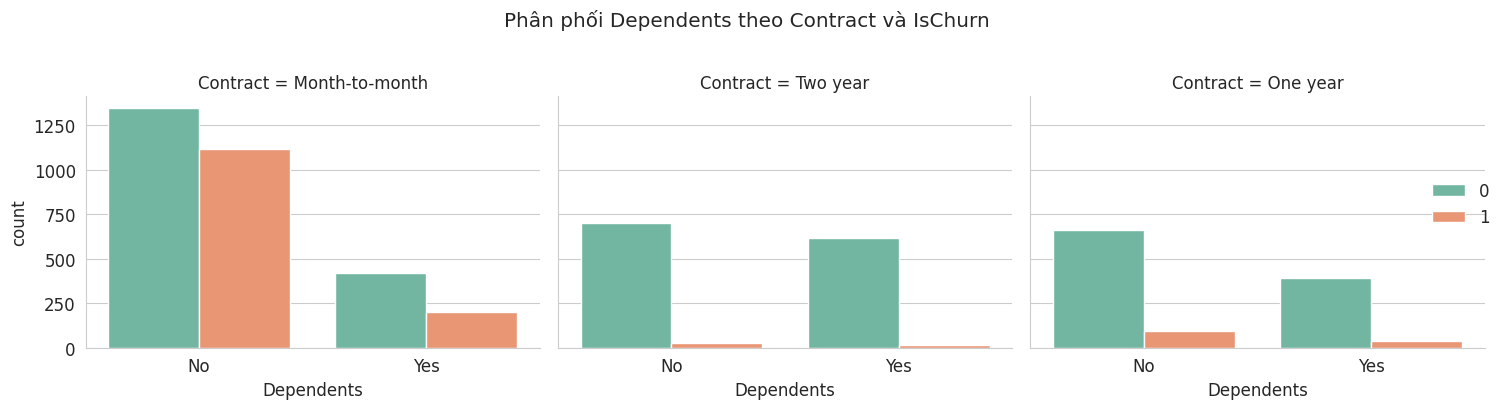

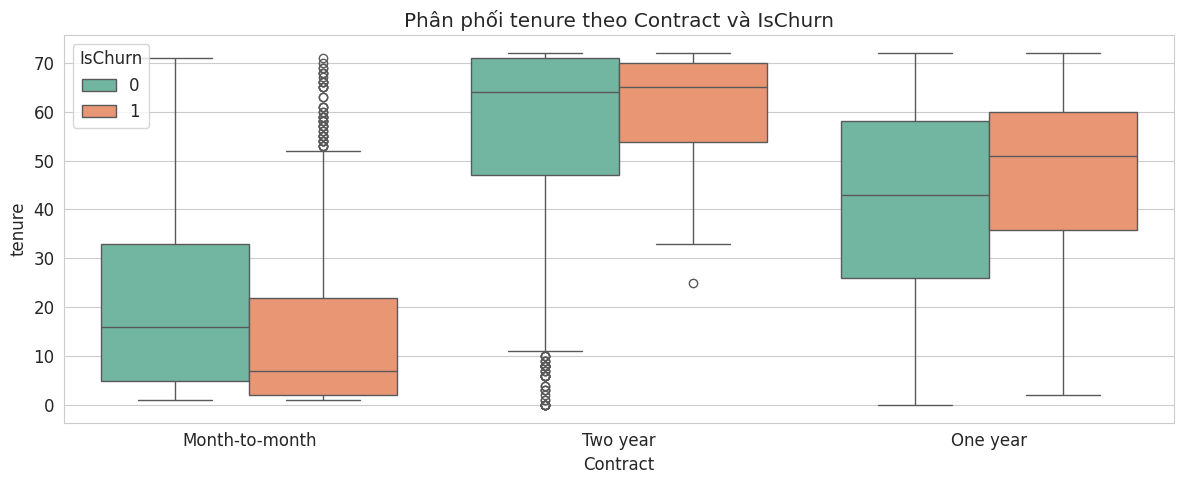

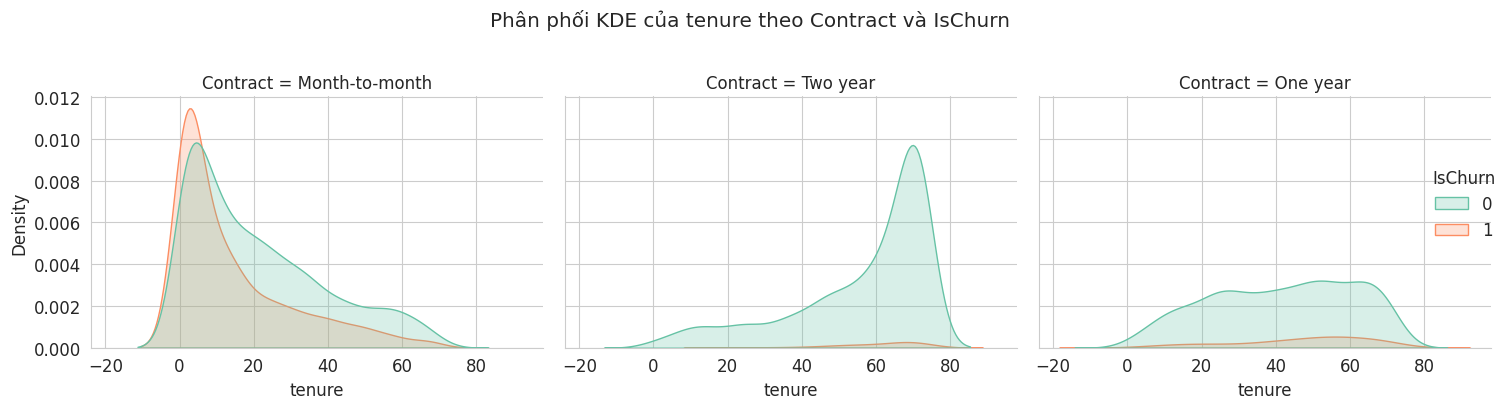

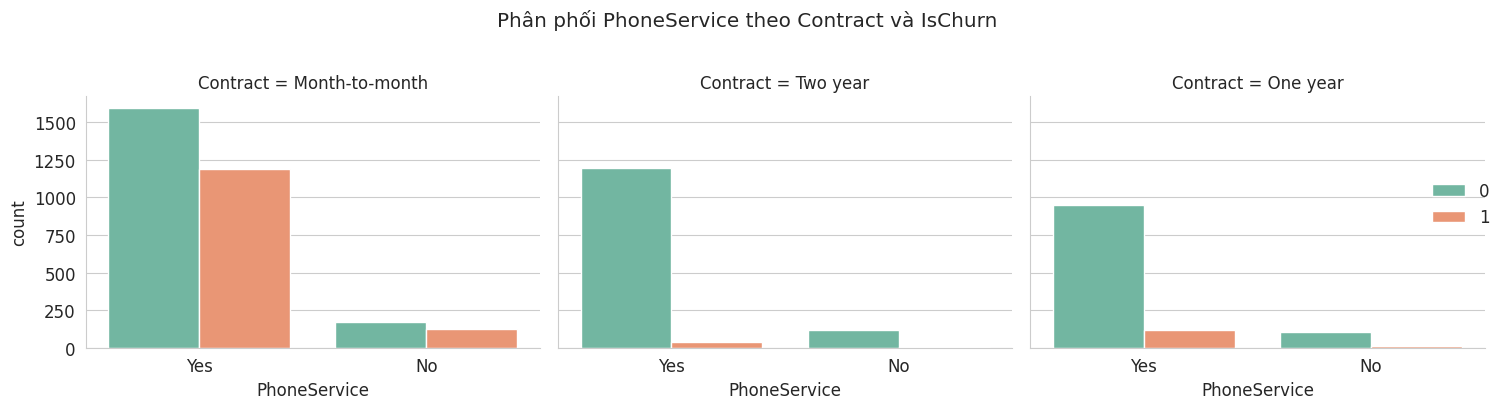

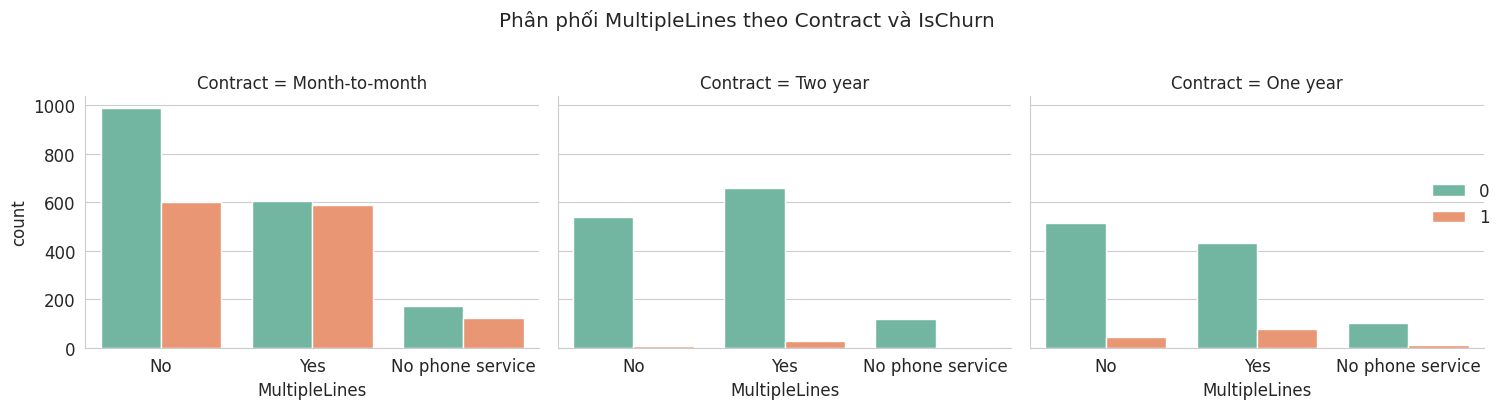

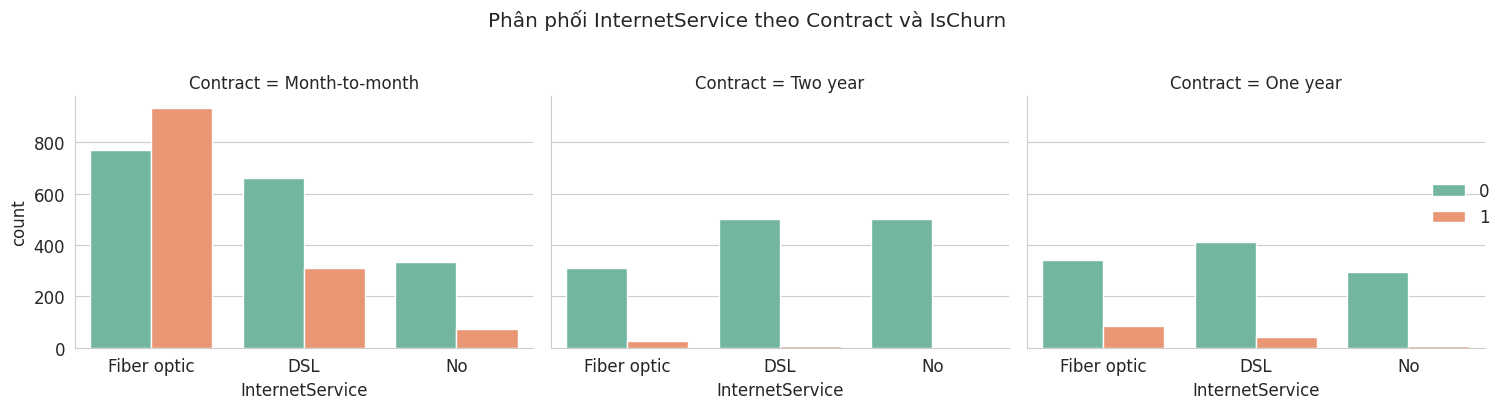

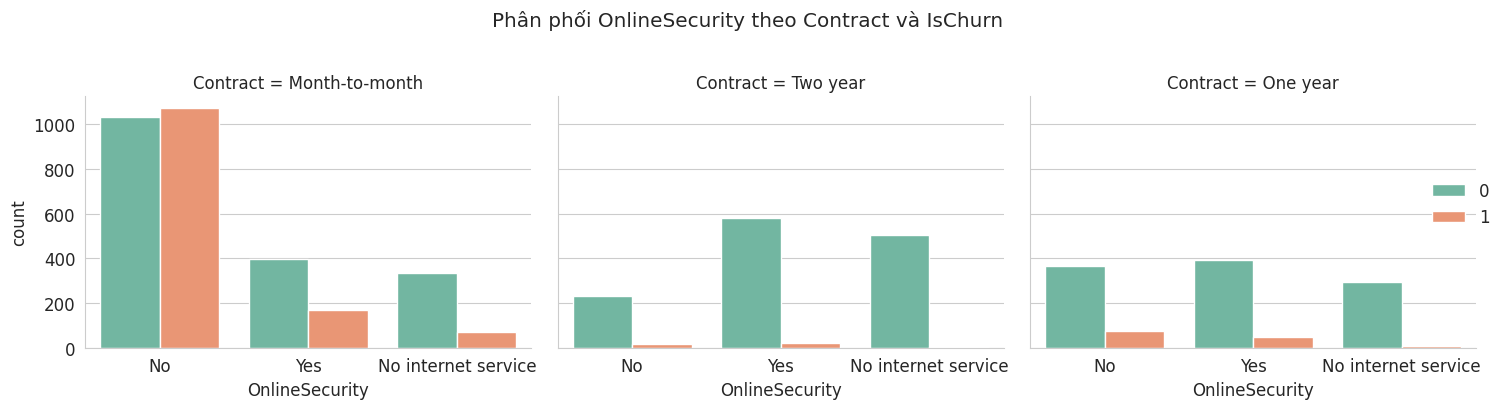

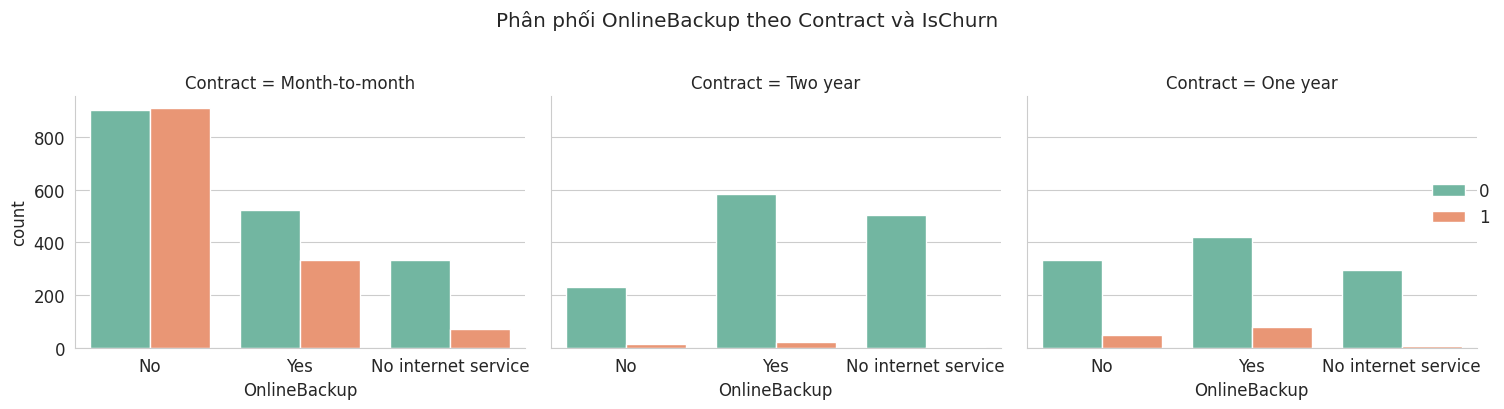

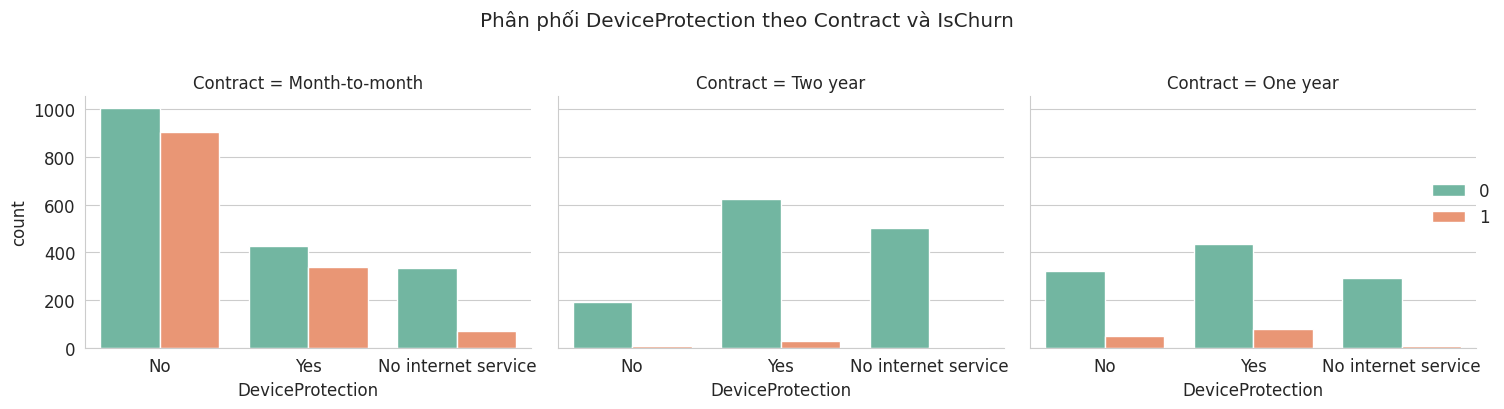

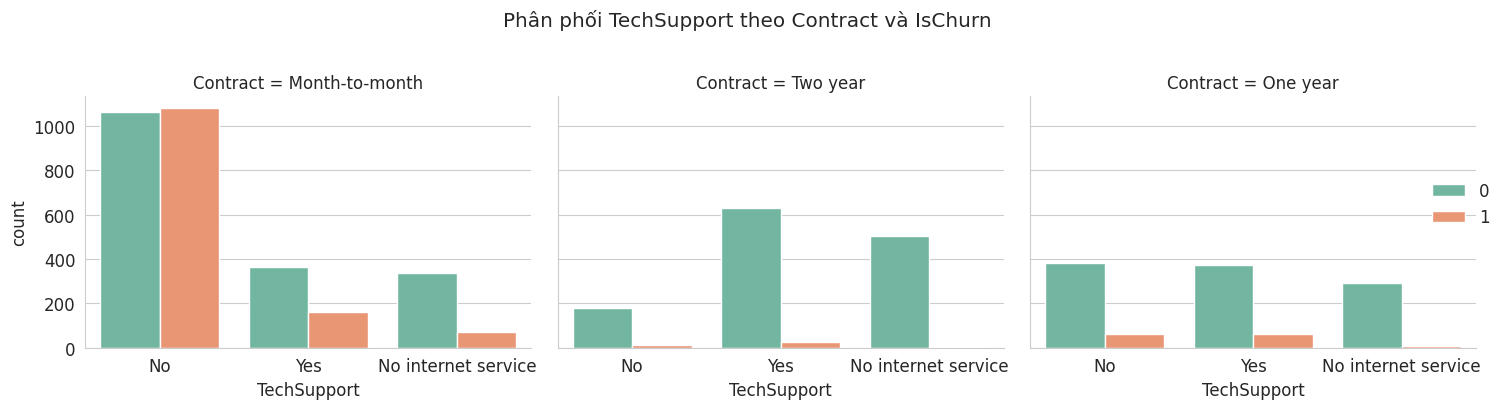

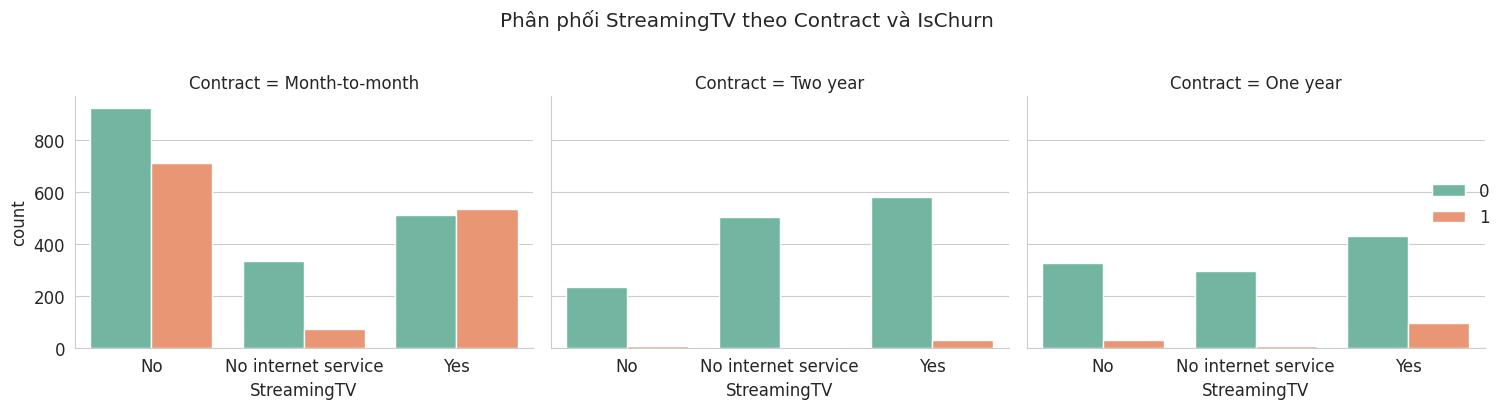

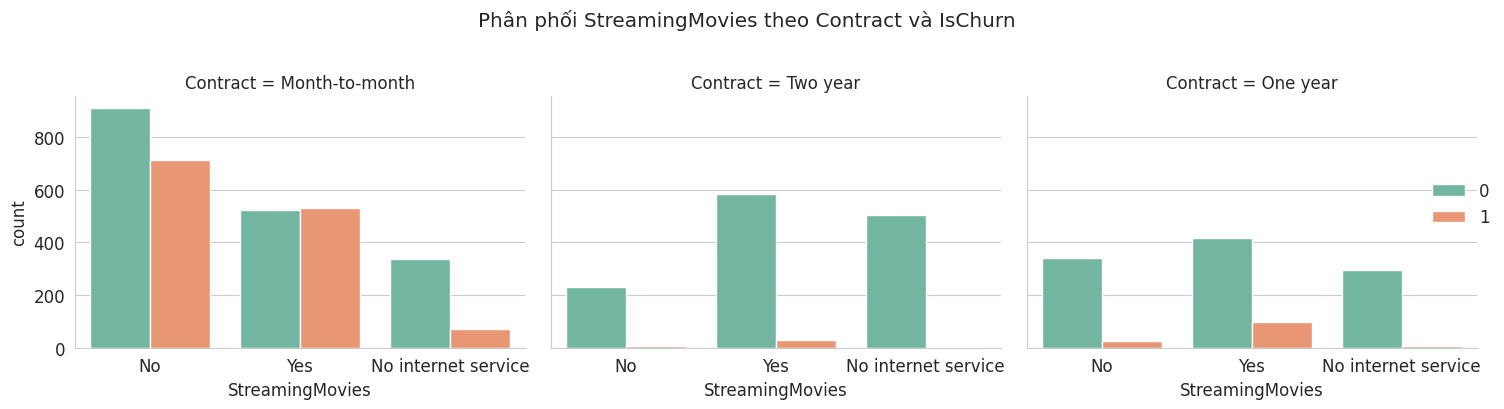

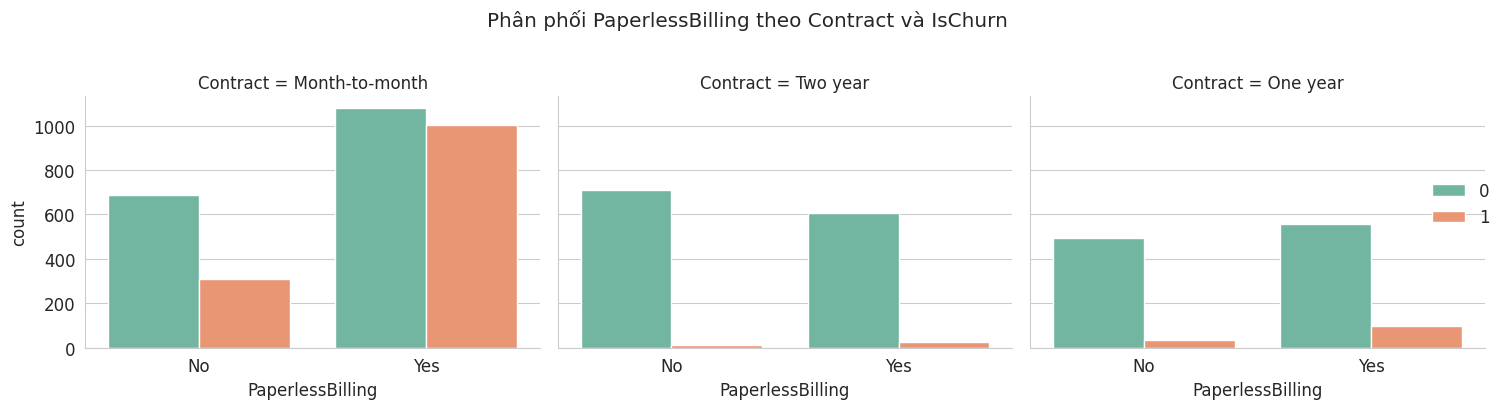

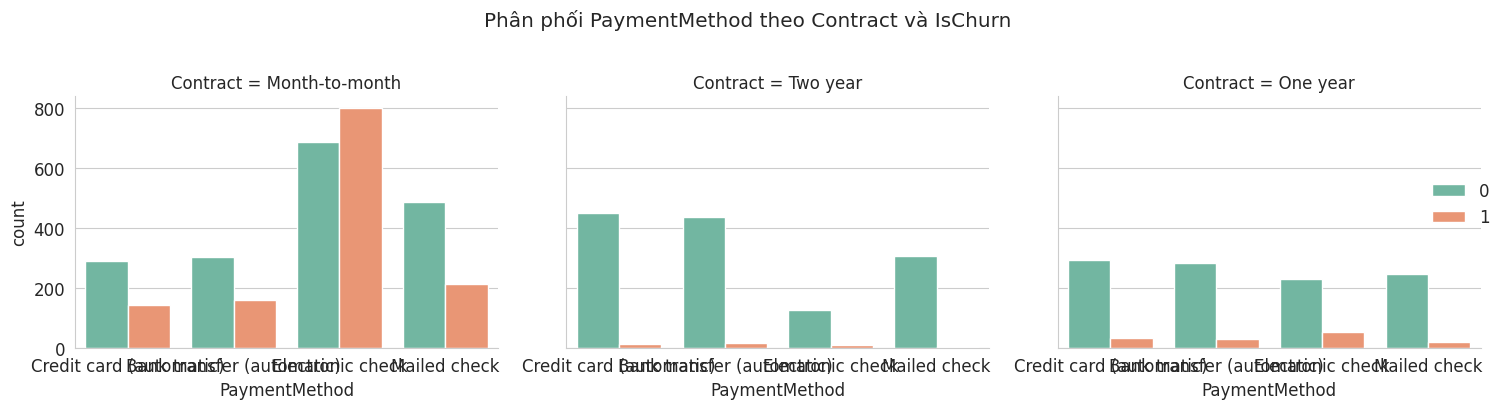

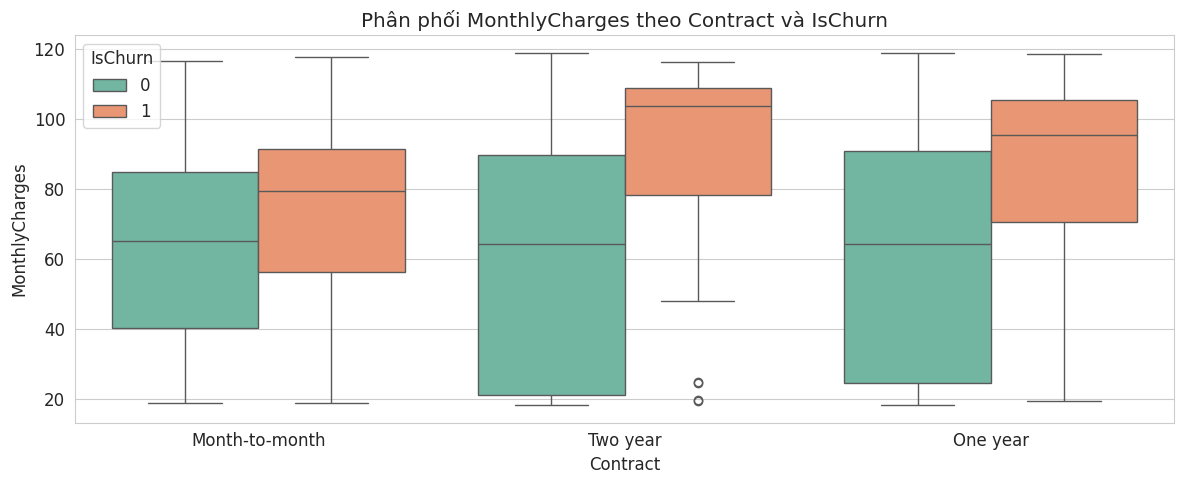

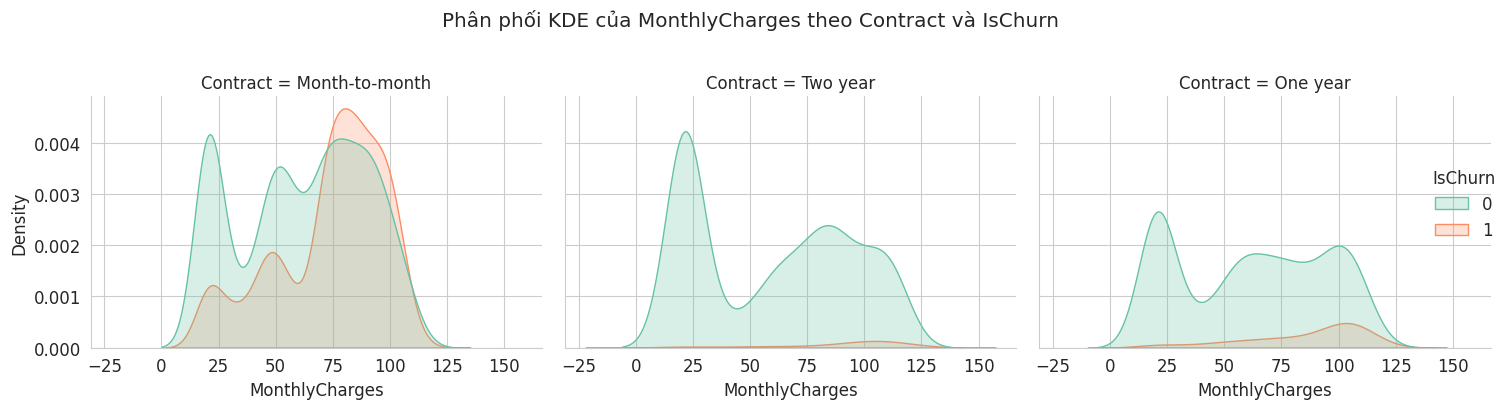

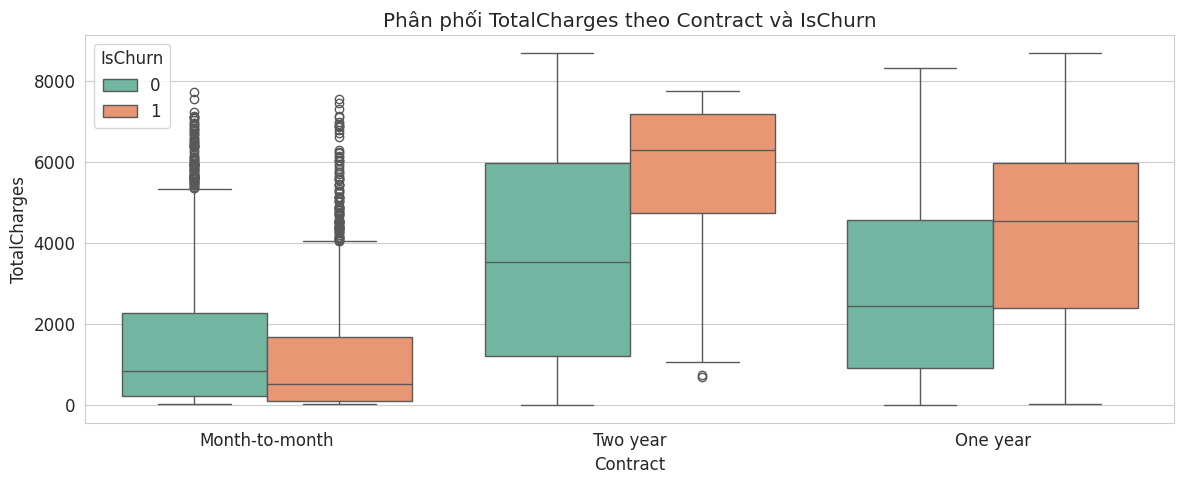

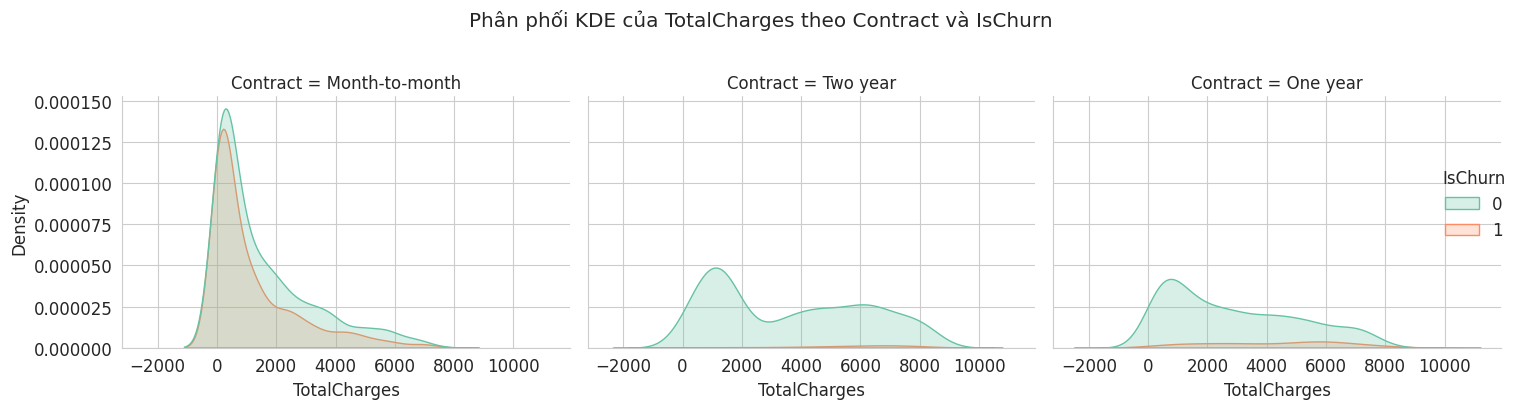

In [ ]:
# Ta cùng xem đặc điểm của month-to-month là gì nhé
for col in df_train.columns:
    if col not in ["IsChurn", "Contract"]:
        if df_train[col].dtype == "object" or df_train[col].nunique() <= 3:
            # Biến categorical: dùng FacetGrid với countplot
            g = sns.FacetGrid(df_train, col="Contract", height=4, aspect=1.2)
            g.map_dataframe(sns.countplot, x=col, hue="IsChurn", palette="Set2")
            g.add_legend()
            g.fig.suptitle(f'Phân phối {col} theo Contract và IsChurn', y=1.02)
            plt.tight_layout()
            plt.show()
        else:
            # Biến numeric: dùng boxplot
            plt.figure(figsize=(12, 5))
            sns.boxplot(data=df_train, x="Contract", y=col, hue="IsChurn", palette="Set2")
            plt.title(f'Phân phối {col} theo Contract và IsChurn')
            plt.tight_layout()
            plt.show()

            # Thêm facet KDE để xem phân phối chi tiết
            g = sns.displot(data=df_train, x=col, col="Contract", hue="IsChurn",
                           kind="kde", fill=True, height=4, aspect=1.2, palette="Set2")
            g.fig.suptitle(f'Phân phối KDE của {col} theo Contract và IsChurn', y=1.02)
            plt.tight_layout()
            plt.show()

**Insight**:
+ Khách hàng cao tuổi có xu hướng rời đi cao hơn so với khách hàng không cao tuổi khi ký hợp đồng ngắn hạn. Hơn nữa, khách hàng cao tuổi có sự e ngại khi đăng ký các gói "One Year/Two year".
+ Khách hàng đăng ký nhiều đường dây điện thoại khi đăng ký hợp đồng ngắn hạn đang có xu hướng rời bỏ nhiều hơn so với "No MultipleLines và No Phone Service". Có vẻ như là dịch vụ đi kèm "MultipleLines" chưa đủ hấp dẫn níu kéo khách sao ?
+ Tiếp tục quan sát thì ta thấy ở Contract = Month-to-month, InternetService có tên là Fiber optic có số lượng churn cao hơn đáng kể so với no churn. Các dịch vụ khác với cùng Contract = Month-to-month thì thấp hơn nhiều so với nochurrn. Nếu ta tiếp tục chú ý đến Contract = Two year và One year, ta càng thấy được rằng Fiber optic thực sự đang có vấn đề vì: churn ở Fiber optic luôn cao hơn so với churn ở các InternetService khác. Từ quan sát trên ta có thể có giả thuyết rằng: Fiber Optic thực sự đang gặp vấn đề nào đó khiến cho những khách hàng kể cả ký hợp đồng dài hay ngắn hạn đều bỏ đi -> Ta cần xem xét lại thật kỹ dịch vụ này ngay lập tức
+ Những người không đăng ký dịch vụ OnlineSecurity khi kết hợp đồng Month-to-month có xu hướng là rời bỏ nhiều hơn so với việc khi người đó đăng ký dịch vụ OnlineSecurity.
+ Tương tự, việc không đăng ký Tech Support cũng cho thấy dấu hiệu rằng tỷ lệ Churn tăng cao hơn so với bình thường ở trong contract month-to-month
+ Đối với dịch vụ StreamingTV, dường như nó cũng có vấn đề giống với Fiber optic (InternetService), ta cần xem xét kỹ dịch vụ này
+ Ở payment method, Electronic check cũng là dấu hiệu cao cho thấy Churn khi Contract là Month-to-month.
+ Để ý kỹ đến TotalCharges với Contract = One/Two year, ta nhận thấy rằng dường như ta đang để mất đi "những khách hàng sộp" vì biểu đồ hộp cho ta thấy được rằng Churn tập trung chủ yếu ở những khách hàng chi tiêu cao hơ nhiều so với những khách hàng không Churn. Vậy nên ta cần có kế hoạch tìm hiểu và giữ chân những khách hàng sộp này lại vì họ đóng góp rất nhiều cho doanh thu công ty: chăm sóc họ kỹ hơn, gợi ý họ những ưu đãi tốt hơn, ...

**Từ những quan sát trên, tôi có lời khuyên như sau**:
1. Về Sản phẩm & Dịch vụ (Product & Services)

- **Ưu tiên #1: Điều tra khẩn cấp dịch vụ `Fiber Optic`**.
  - Thành lập đội đặc nhiệm (Task Force) để phân tích nguyên nhân gốc rễ (giá, chất lượng mạng, đối thủ cạnh tranh, trải nghiệm lắp đặt).
  - Đây là nguyên nhân gây churn lớn nhất trên mọi loại hợp đồng.

- **Đánh giá lại các dịch vụ đi kèm (Add-on Services)**.
  - Phân tích lý do `MultipleLines` và `StreamingTV` không đủ sức giữ chân khách hàng hợp đồng ngắn hạn.
  - Cân nhắc tạo các gói bundle hấp dẫn hơn khi kết hợp với hợp đồng dài hạn.

2. Về Marketing & Bán hàng (Marketing & Sales)

- **Triển khai chiến dịch nhắm vào "phân khúc khách hàng rủi ro cao"**.
  - **Hồ sơ:** Hợp đồng `Month-to-Month` + Không dùng `Online Security`/`Tech Support` + Thanh toán bằng `Electronic Check`.
  - **Hành động:** Cung cấp ưu đãi dùng thử/giảm giá cho các dịch vụ add-on để tăng "độ dính".

- **Thiết kế gói cước linh hoạt cho người cao tuổi (`SeniorCitizen`)**.
  - Tạo các gói "1 năm linh hoạt" (ví dụ: có điều khoản hủy dễ dàng) để giảm bớt e ngại cam kết dài hạn của họ.

3. Về Chăm sóc & Giữ chân Khách hàng (Customer Success & Retention)

- **Xây dựng quy trình giữ chân "khách hàng VIP"**.
  - **Xác định:** Khách hàng có `TotalCharges` cao, hợp đồng `One/Two year` sắp hết hạn.
  - **Hành động:** Chủ động liên hệ **3 tháng trước khi hết hạn** để đưa ra các ưu đãi gia hạn độc quyền và cá nhân hóa.

- **Chủ động bán thêm (Upsell) các dịch vụ bảo vệ**.
  - Đào tạo đội ngũ CSKH để gợi ý các gói `Online Security` và `Tech Support` khi khách hàng liên hệ hỗ trợ, nhấn mạnh lợi ích giảm thiểu rủi ro.

#### Tenure

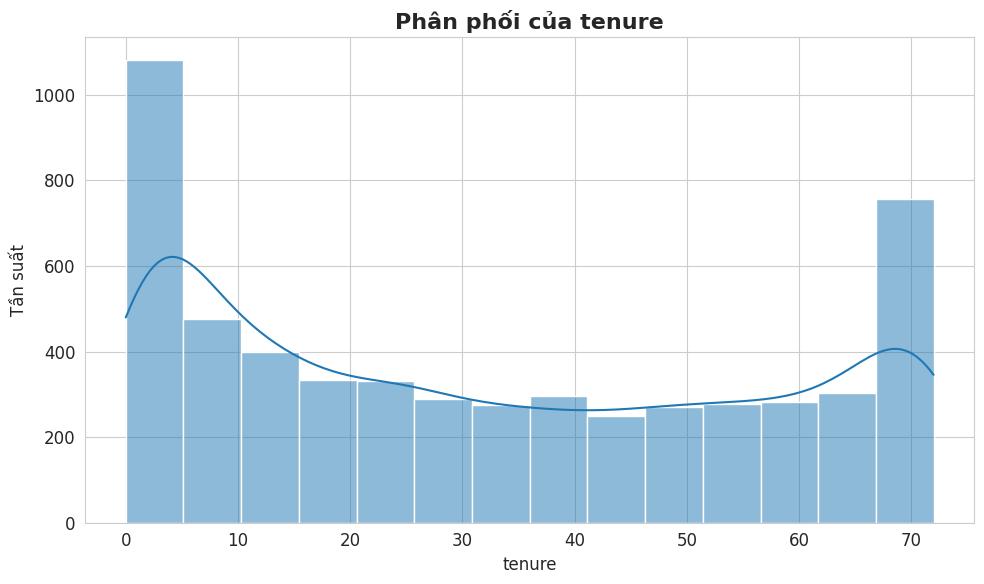

In [ ]:
plot_distribution(df_train, "tenure");

Chúng ta đang có nhiều khách hàng trung thành nhưng khách hàng mới là chiếm nhiều nhất

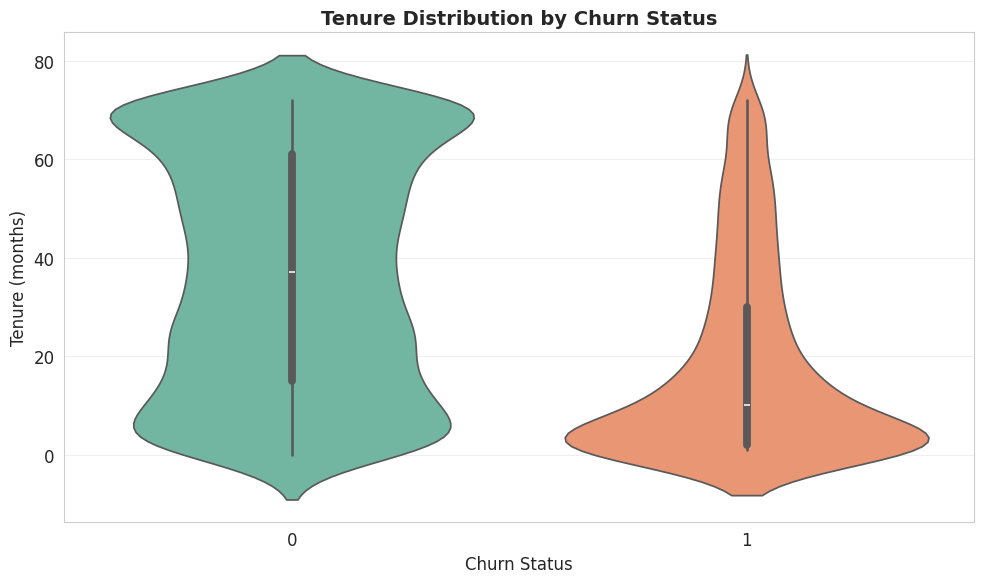

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='IsChurn', y='tenure', data=df_train, palette='Set2', ax=ax)
ax.set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Churn Status', fontsize=12)
ax.set_ylabel('Tenure (months)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Insight**:
- Những khách hàng có tỷ lệ churn cao tập trung chủ yếu là những khách hàng mới với số tháng chủ yếu là khoảng 5-10 tháng. Khi gắn bó càng lâu thì càng ít có khả năng rời bỏ (ta có thể thấy khách hàng không rời bỏ tập trung nhiều ở chỗ > 60 tenures)


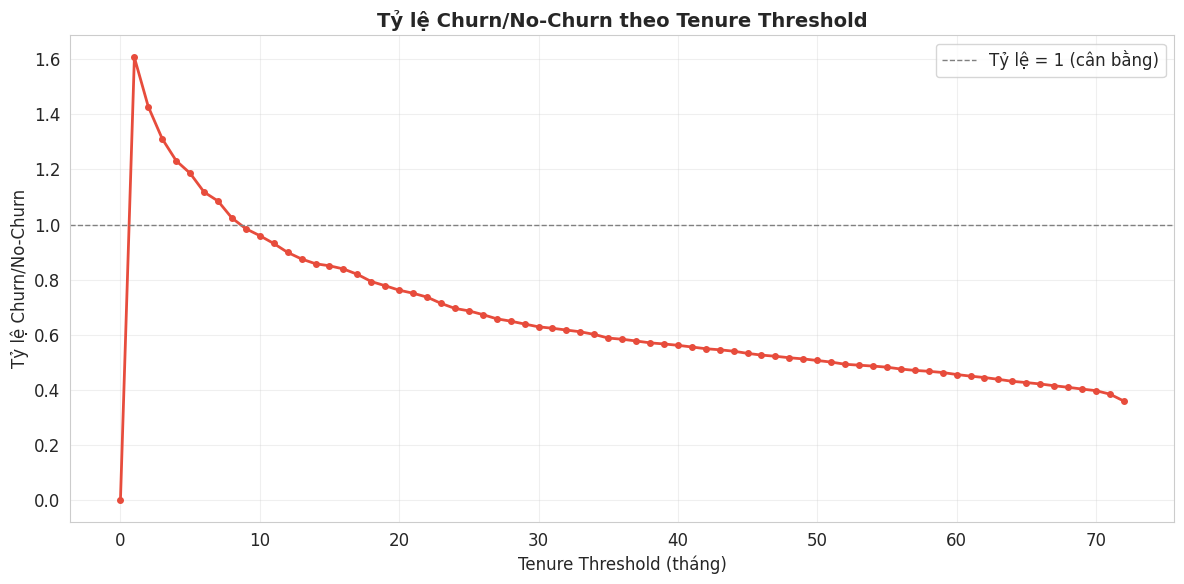

In [ ]:
# Tính tỷ lệ churn/no_churn theo từng ngưỡng tenure
thresholds = []
ratios = []

for threshold in sorted(df_train["tenure"].unique()):
    df_tenure_threshold = df_train[df_train["tenure"] <= threshold]
    count_churn = df_tenure_threshold[df_tenure_threshold["IsChurn"] == 1]
    count_no_churn = df_tenure_threshold[df_tenure_threshold["IsChurn"] == 0]

    if len(count_no_churn) > 0:
        ratio = len(count_churn) / len(count_no_churn)
        thresholds.append(threshold)
        ratios.append(ratio)

# Vẽ đồ thị đường
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds, ratios, marker='o', linewidth=2, markersize=4, color='#e74c3c')
ax.set_title('Tỷ lệ Churn/No-Churn theo Tenure Threshold', fontsize=14, fontweight='bold')
ax.set_xlabel('Tenure Threshold (tháng)', fontsize=12)
ax.set_ylabel('Tỷ lệ Churn/No-Churn', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='Tỷ lệ = 1 (cân bằng)')
ax.legend()
plt.tight_layout()
plt.show()

**Insight:**  
Nhìn vào đồ thị trên ta thấy tính từ tháng 8 đồ đi thì tỷ lệ rời đi/ở lại là < 1. Vậy tôi coi những khách hàng khi tenure nằm trong tháng 1 đến tháng 8 là những tháng NGUY HIỂM, ta cần đầy mạnh việc chăm sóc khách hàng và cần có những cách giữ chân khách hàng phù hợp trong giai đoạn này

#### MonthlyCharges

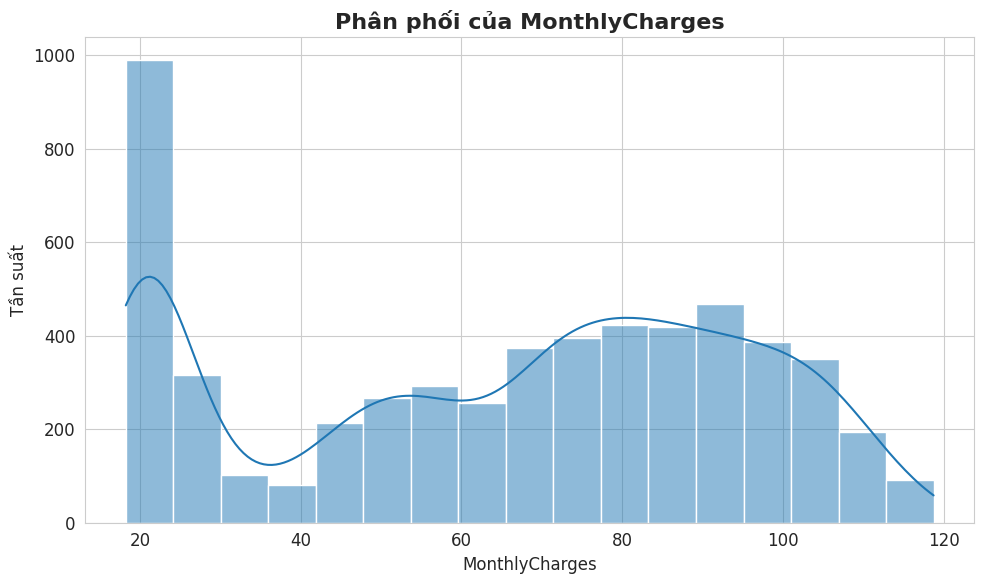

In [ ]:
plot_distribution(df_train,"MonthlyCharges");

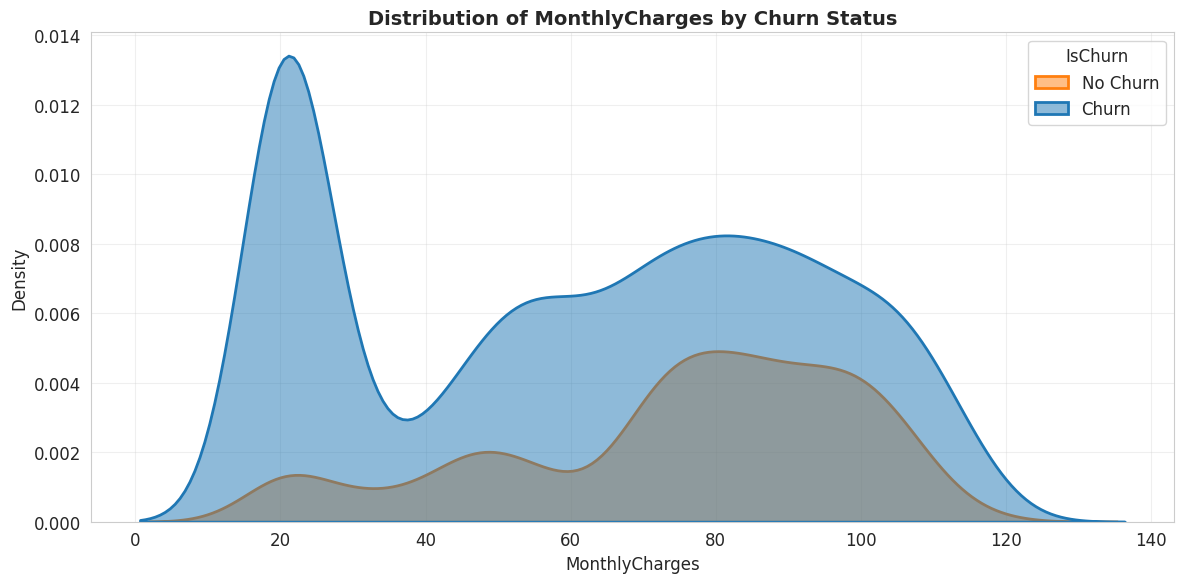

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_train, x="MonthlyCharges", hue="IsChurn", fill=True, alpha=0.5, linewidth=2)
plt.title('Distribution of MonthlyCharges by Churn Status', fontsize=14, fontweight='bold')
plt.xlabel('MonthlyCharges', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='IsChurn', labels=['No Churn', 'Churn'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

-> 2 đồ thị Churn và No Churn tương đối giống nhau, tôi chưa thấy gì đặc biệt lắm

#### Online Security

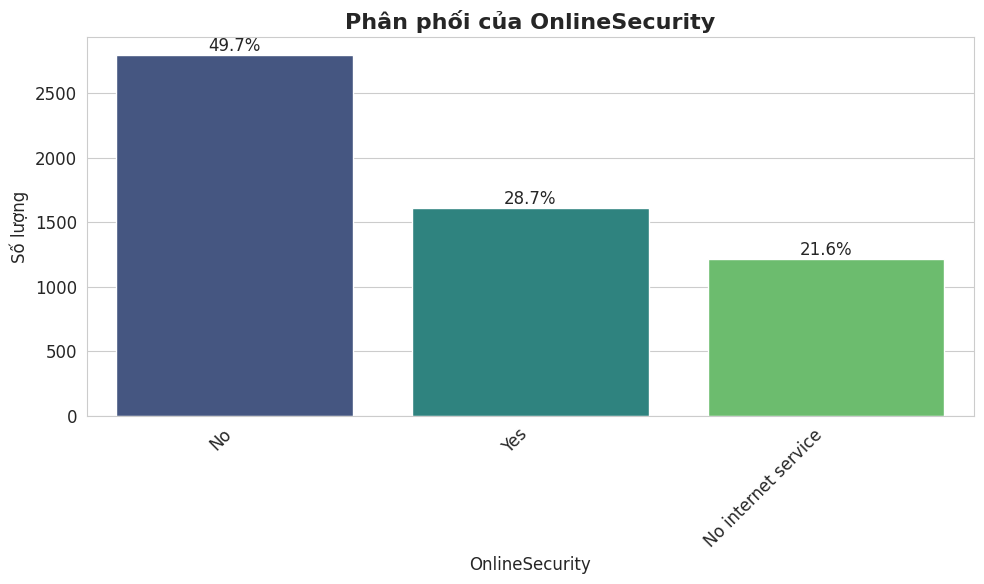

In [ ]:
plot_count(df_train,"OnlineSecurity");

<Figure size 1000x600 with 0 Axes>

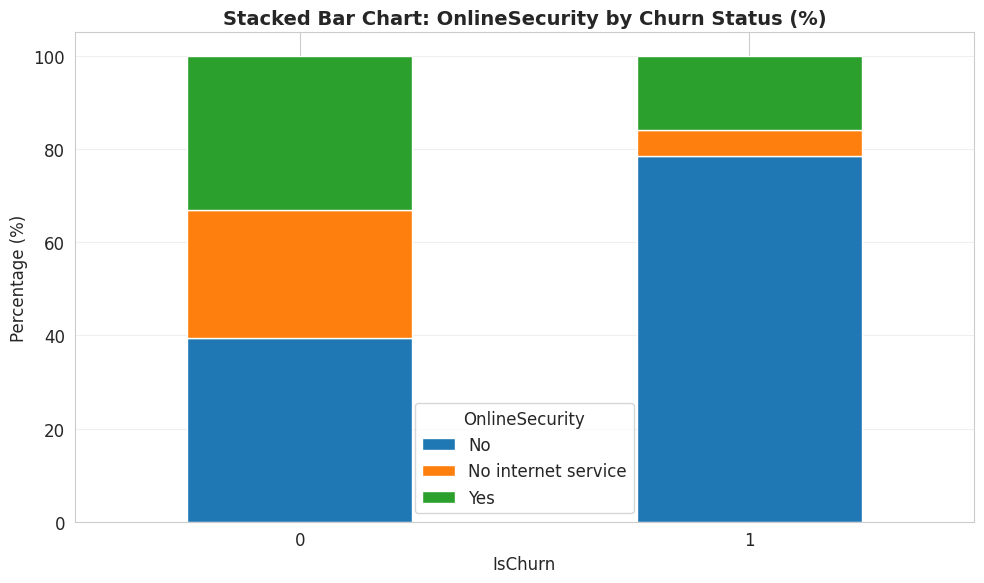

In [ ]:
plt.figure(figsize=(10, 6))
df_train.groupby(['IsChurn', 'OnlineSecurity']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart: OnlineSecurity by Churn Status (%)', fontsize=14, fontweight='bold')
plt.xlabel('IsChurn', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='OnlineSecurity')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


-> 80% khách hàng rời bỏ là không đăng ký Online Security, trong khi đối chiếu với việc không rời bỏ thì con số này chỉ là khoảng 65%.  
-> Việc khách hàng ko sử dụng dịch vụ OnlineSecurity là 1 trong những dấu hiệu cho thấy khách hàng có nguy cơ rời bỏ

#### TechSupport

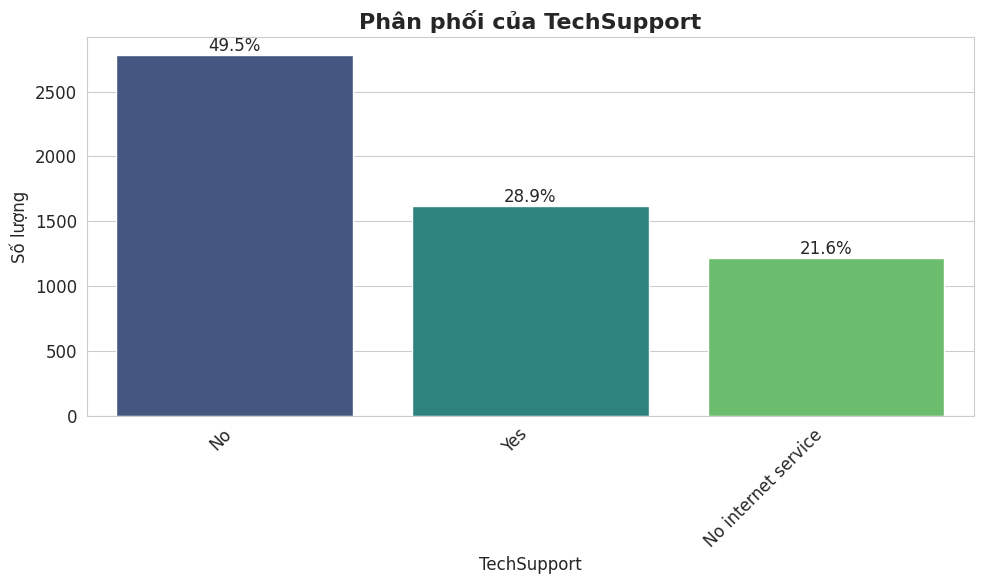

In [ ]:
plot_count(df_train,"TechSupport");

<Figure size 1000x600 with 0 Axes>

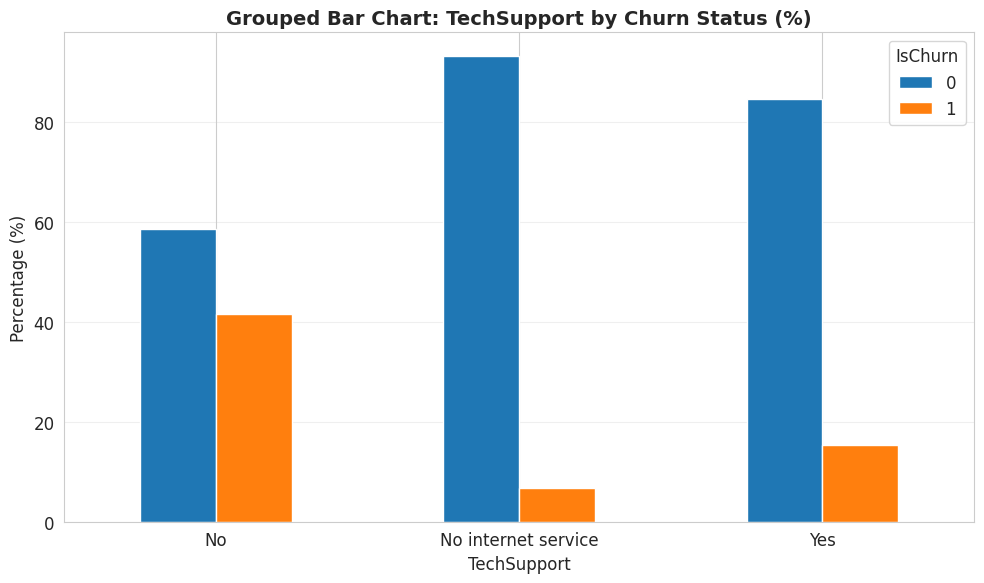

In [ ]:
plt.figure(figsize=(10, 6))
df_train.groupby(['TechSupport', 'IsChurn']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=False)
plt.title('Grouped Bar Chart: TechSupport by Churn Status (%)', fontsize=14, fontweight='bold')
plt.xlabel('TechSupport', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='IsChurn')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


**Tech Support là biến quyết định chính chung:** Khách có Tech Support churn chỉ ~15%, trong khi không có Tech Support churn ~42%—gấp gần 3 lần. Đây là tín hiệu hành động rõ ràng: tập trung upsell Tech Support cho khách đang ở trạng thái "No".

**Nhóm "No internet service" bất thường:** Churn rất thấp (~8%), thấp hơn cả nhóm "Yes"; điều này gợi ý rằng:
- Nhóm này có thể là khách lâu năm, loyalty cao, dùng dịch vụ cơ bản (điện thoại) và ít churn tự nhiên.
- Hoặc là khách không phải target chính của dịch vụ internet, nên kém quan tâm đến Tech Support và tự ít kỳ vọng hơn.

**Rủi ro tập trung ở "No":** Hơn 40% khách không có Tech Support rời đi—đó là mất mát lớn; cần kiểm tra tại sao khách lại chọn không mua dịch vụ này (giá, hiểu biết không đủ, chất lượng bị nghi ngờ…).

#### Đối với các biến khác, tôi sẽ chỉ tập trung xem phân phối dữ liệu và count_plot thôi

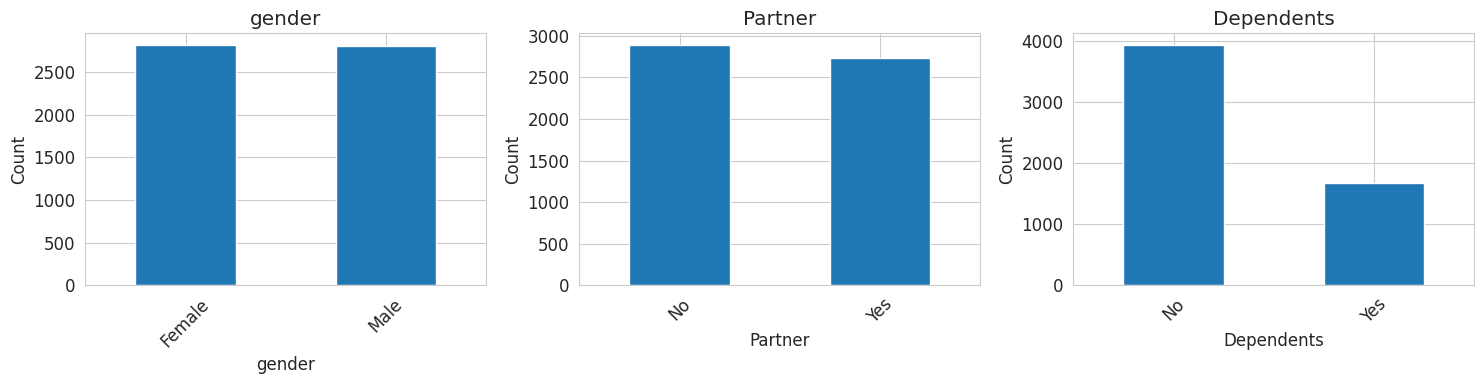

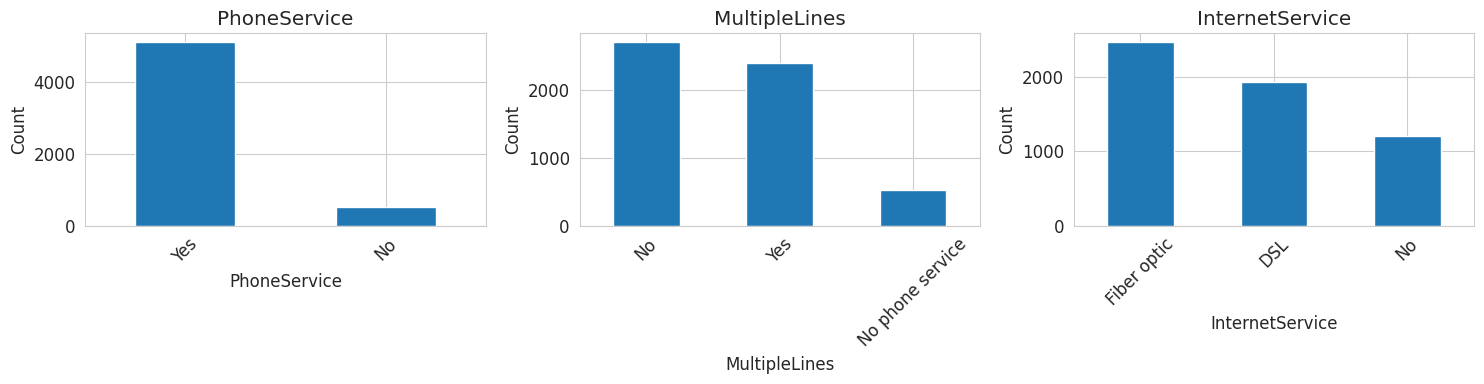

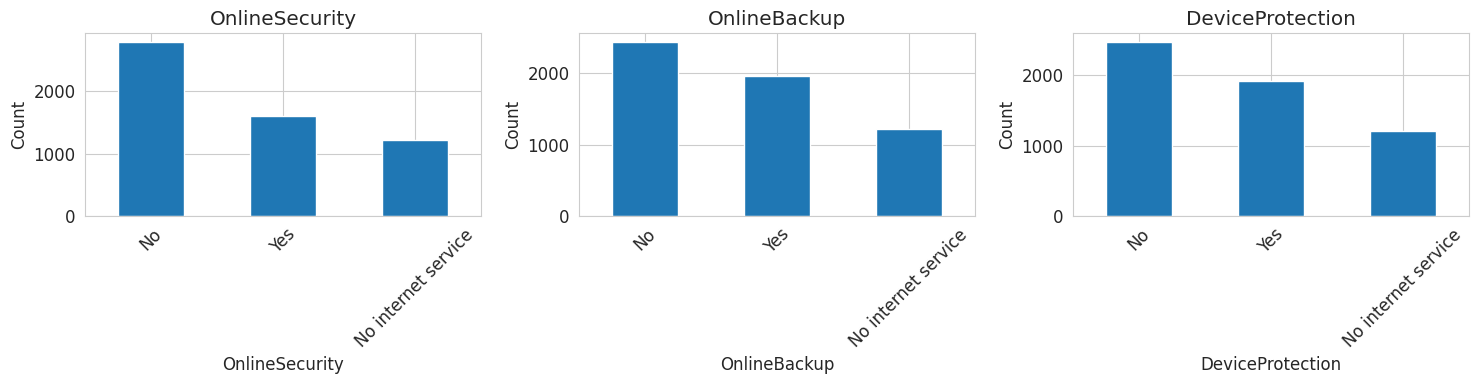

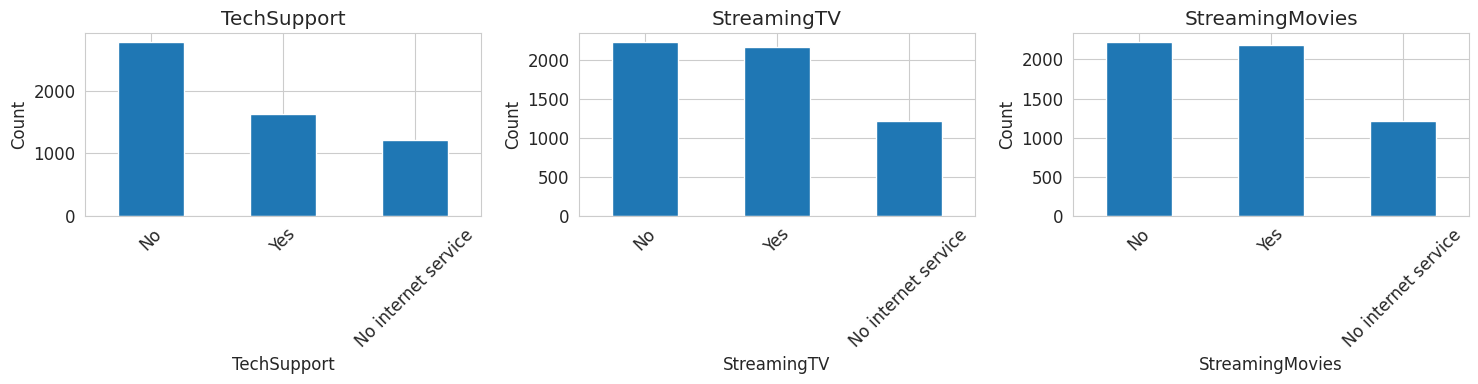

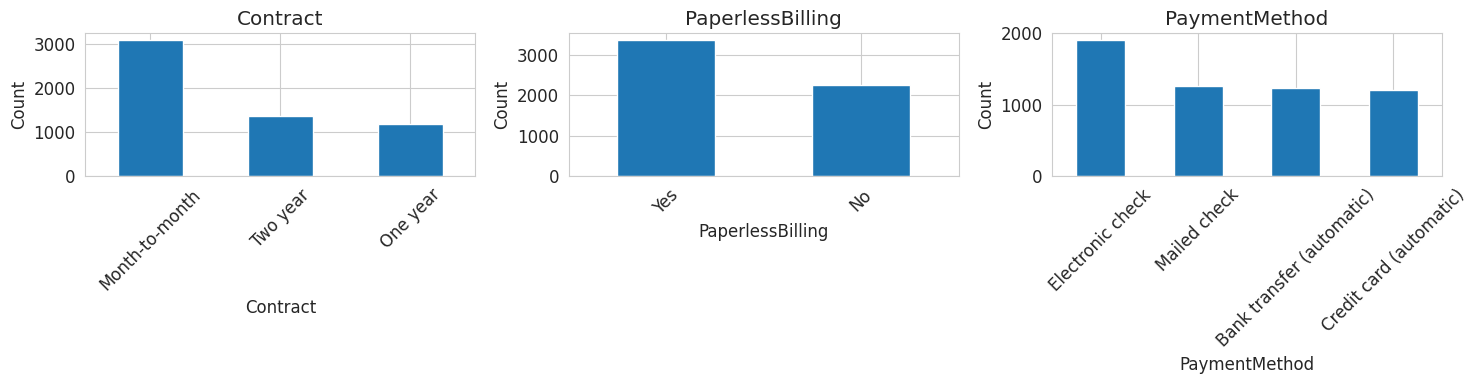

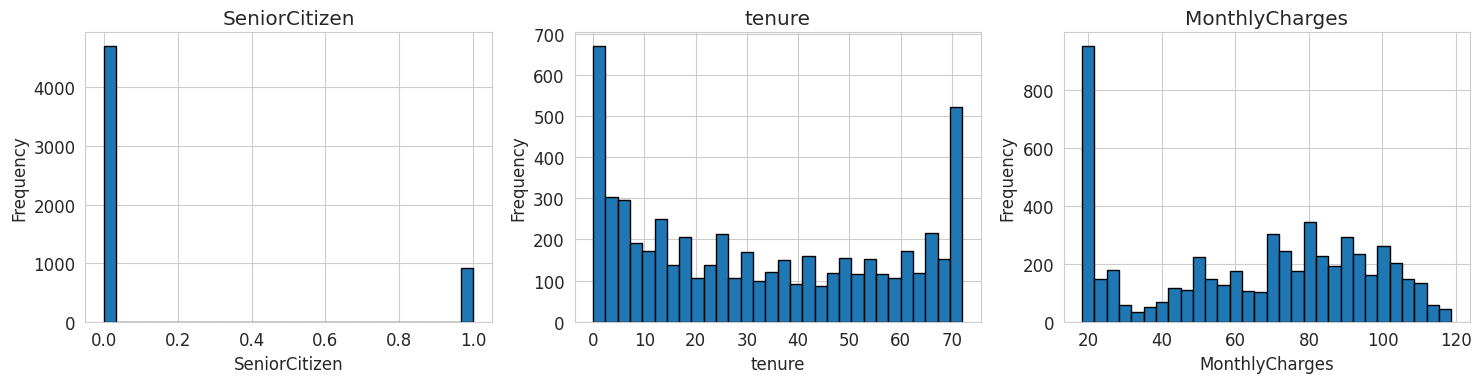

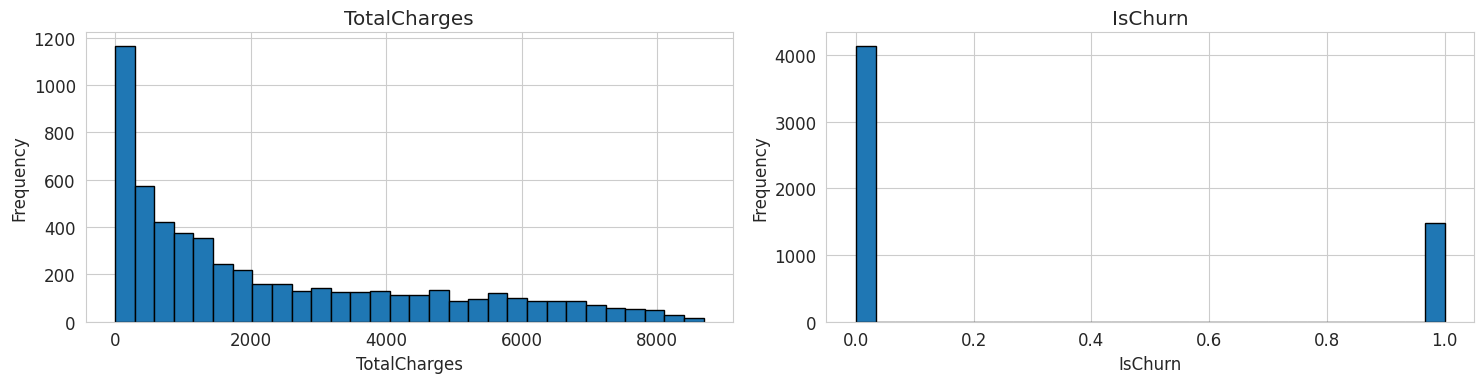

In [ ]:
# Separate categorical and numerical columns
categorical_cols = [col for col in df_train.columns if df_train[col].dtype == 'object']
numerical_cols = [col for col in df_train.columns if df_train[col].dtype != 'object']

# Plot categorical variables
for i in range(0, len(categorical_cols), 3):
    cols_to_plot = categorical_cols[i:i+3]
    fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(15, 4))
    if len(cols_to_plot) == 1:
        axes = [axes]

    for idx, col in enumerate(cols_to_plot):
        df_train[col].value_counts().plot(kind='bar', ax=axes[idx])
        axes[idx].set_title(f'{col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Plot numerical variables
for i in range(0, len(numerical_cols), 3):
    cols_to_plot = numerical_cols[i:i+3]
    fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(15, 4))
    if len(cols_to_plot) == 1:
        axes = [axes]

    for idx, col in enumerate(cols_to_plot):
        axes[idx].hist(df_train[col].dropna(), bins=30, edgecolor='black')
        axes[idx].set_title(f'{col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

## **Feature Engineering**

### 1. Tạo biến: IsSeniorShortTerm để mô hình có thể tập trung hơn cho việc xử lý senior vì như EDA ta thấy senior có xu hướng churn cao

In [ ]:
df_train["IsSeniorShortTerm"] = ((df_train["SeniorCitizen"] == 1) & (df_train["Contract"] == 'Month-to-month')).astype(int)
df_test["IsSeniorShortTerm"] = ((df_test["SeniorCitizen"] == 1) & (df_test["Contract"] == 'Month-to-month')).astype(int)

### 2. StreamingMovies và StreamingTV cũng gặp vấn đề giống với InternetService Fiber Optic. Tôi sẽ gộp cả 2 vào luôn và tạo 1 biến mới có tên: HasStreaming

In [ ]:
df_train["HasStreaming"] = ((df_train["StreamingMovies"] == "Yes") | (df_train["StreamingTV"] == "Yes")).astype(int)
df_test["HasStreaming"] = ((df_test["StreamingMovies"] == "Yes") | (df_test["StreamingTV"] == "Yes")).astype(int)

### 3. Việc 1 khách hàng không đăng ký các dịch vụ đi kèm như: OnlineBackup, OnlineSecurity và TechSupport khi ký kết hợp đồng month-to-month là dấu hiệu mạnh mẽ của việc khách hàng ấy sẽ rời bỏ đi. Tôi sẽ tạo 1 biến mạnh là sự kết hợp của 3 biến này

In [ ]:
df_train["RegisterService"] = (
    (df_train["OnlineBackup"] == "No") &
    (df_train["OnlineSecurity"] == "No") &
    (df_train["TechSupport"] == "No") &
    (df_train["Contract"] == "Month-to-month")
).astype(int)

df_test["RegisterService"] = (
    (df_test["OnlineBackup"] == "No") &
    (df_test["OnlineSecurity"] == "No") &
    (df_test["TechSupport"] == "No") &
    (df_test["Contract"] == "Month-to-month")
).astype(int)

### 4. PaymentMethod là ElectronicCheck với hợp đồng là Month-to-month cũng là dấu hiệu mạnh mẽ của việc rời bỏ. Tạo biến: IsElectronPay

In [ ]:
df_train["IsElectronPay"] = (
    (df_train["PaymentMethod"] == "Electronic check") &
    (df_train["Contract"] == "Month-to-month")
).astype(int)

df_test["IsElectronPay"] = (
    (df_test["PaymentMethod"] == "Electronic check") &
    (df_test["Contract"] == "Month-to-month")
).astype(int)


### 5. Ánh xạ các biến chữ cho đơn giản + Encoding

Với các dịch vụ đi kèm thì giá trị của nó: No ... service/No/Yes  
**Tôi quyết định sẽ ánh xạ No ... service/No -> No cho đơn giản**

In [ ]:
mapping = {"No phone service":"No", "No internet service":"No"}
mapping_col = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

for col in mapping_col:
    df_train[col] = df_train[col].replace(mapping)
    df_test[col] = df_test[col].replace(mapping)

### 6. Mã hóa:
- Với các cột chữ, với những cột chỉ có Yes/No, tôi dùng LabelEncoding. Còn các cột có các tên cụ thể (InternetService, PaymentMethod, Contract) thì tôi sẽ One-Hot-Encoding
- Các biến số liên tục với những biến lệch trái/phải tôi sử dụng log transform + mã hóa dùng RobustScaler
- Các biến số liên tục tuân theo phân phối chuẩn tôi mã hóa bằng StandardScaler
- Còn các biến sô chỉ có 1/0 thì tôi giữ nguyên

In [ ]:
# 1. Label Encoding cho các cột Yes/No
yes_no_cols = [col for col in df_train.select_dtypes(include="object").columns if col not in ["InternetService", "PaymentMethod", "Contract"]]

le = LabelEncoder()
for col in yes_no_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [ ]:
# 2. OHE

categorical_cols = ["InternetService", "PaymentMethod", "Contract"]

# Bước 1: Fit encoder CHỈ trên train set
encoder = OneHotEncoder(
    handle_unknown='ignore',  # ← Quan trọng: bỏ qua category lạ trong test
    sparse_output=False,
    dtype=int
)
encoder.fit(df_train[categorical_cols])


df_train_ohe = pd.DataFrame(
    encoder.transform(df_train[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_train.index  # ← Quan trọng: dùng lại index gốc
)

df_test_ohe = pd.DataFrame(
    encoder.transform(df_test[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_test.index
)

# Ghép lại
df_train = pd.concat([df_train.drop(categorical_cols, axis=1), df_train_ohe], axis=1)
df_test = pd.concat([df_test.drop(categorical_cols, axis=1), df_test_ohe], axis=1)

In [ ]:
df_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
2629,1,0,0,0,2,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2650,0,0,0,0,15,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
1418,1,0,1,1,67,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
5774,1,0,0,0,5,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
2425,1,0,0,0,26,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


In [ ]:
# 3. Log transform + RobustScaler cho các biến lệch (MonthlyCharges, TotalCharges)
skewed_cols = ["MonthlyCharges", "TotalCharges"]
robust_scaler = RobustScaler()

for col in skewed_cols:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

df_train[skewed_cols] = robust_scaler.fit_transform(df_train[skewed_cols])
df_test[skewed_cols] = robust_scaler.transform(df_test[skewed_cols])

# 4. StandardScaler cho các biến tuân theo phân phối chuẩn (tenure)
normal_cols = ["tenure"]
standard_scaler = StandardScaler()

df_train[normal_cols] = standard_scaler.fit_transform(df_train[normal_cols])
df_test[normal_cols] = standard_scaler.transform(df_test[normal_cols])

# 5. Các biến 0/1 giữ nguyên (SeniorCitizen, các biến feature engineering đã tạo)

## **Huấn luyện mô hình**

### 1. Tách X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test = df_train.drop(columns="IsChurn",axis=1),df_test.drop(columns="IsChurn",axis=1)
y_train, y_test = df_train["IsChurn"],df_test["IsChurn"]

### 2. Huấn luyện mô hình baseline: Logistic Regression

In [ ]:
feature_names = X_train.columns.tolist()

=== Đánh giá mô hình Logistic Regression ===
Train Accuracy: 0.8118
Test Accuracy: 0.8021
Test Precision: 0.7918
Test Recall: 0.8021
Test F1-Score: 0.7937
Test ROC-AUC: 0.8419

Classification Report (Test):
              precision    recall  f1-score   support

    No Churn       0.84      0.91      0.87      1033
       Churn       0.66      0.52      0.58       372

    accuracy                           0.80      1405
   macro avg       0.75      0.71      0.73      1405
weighted avg       0.79      0.80      0.79      1405



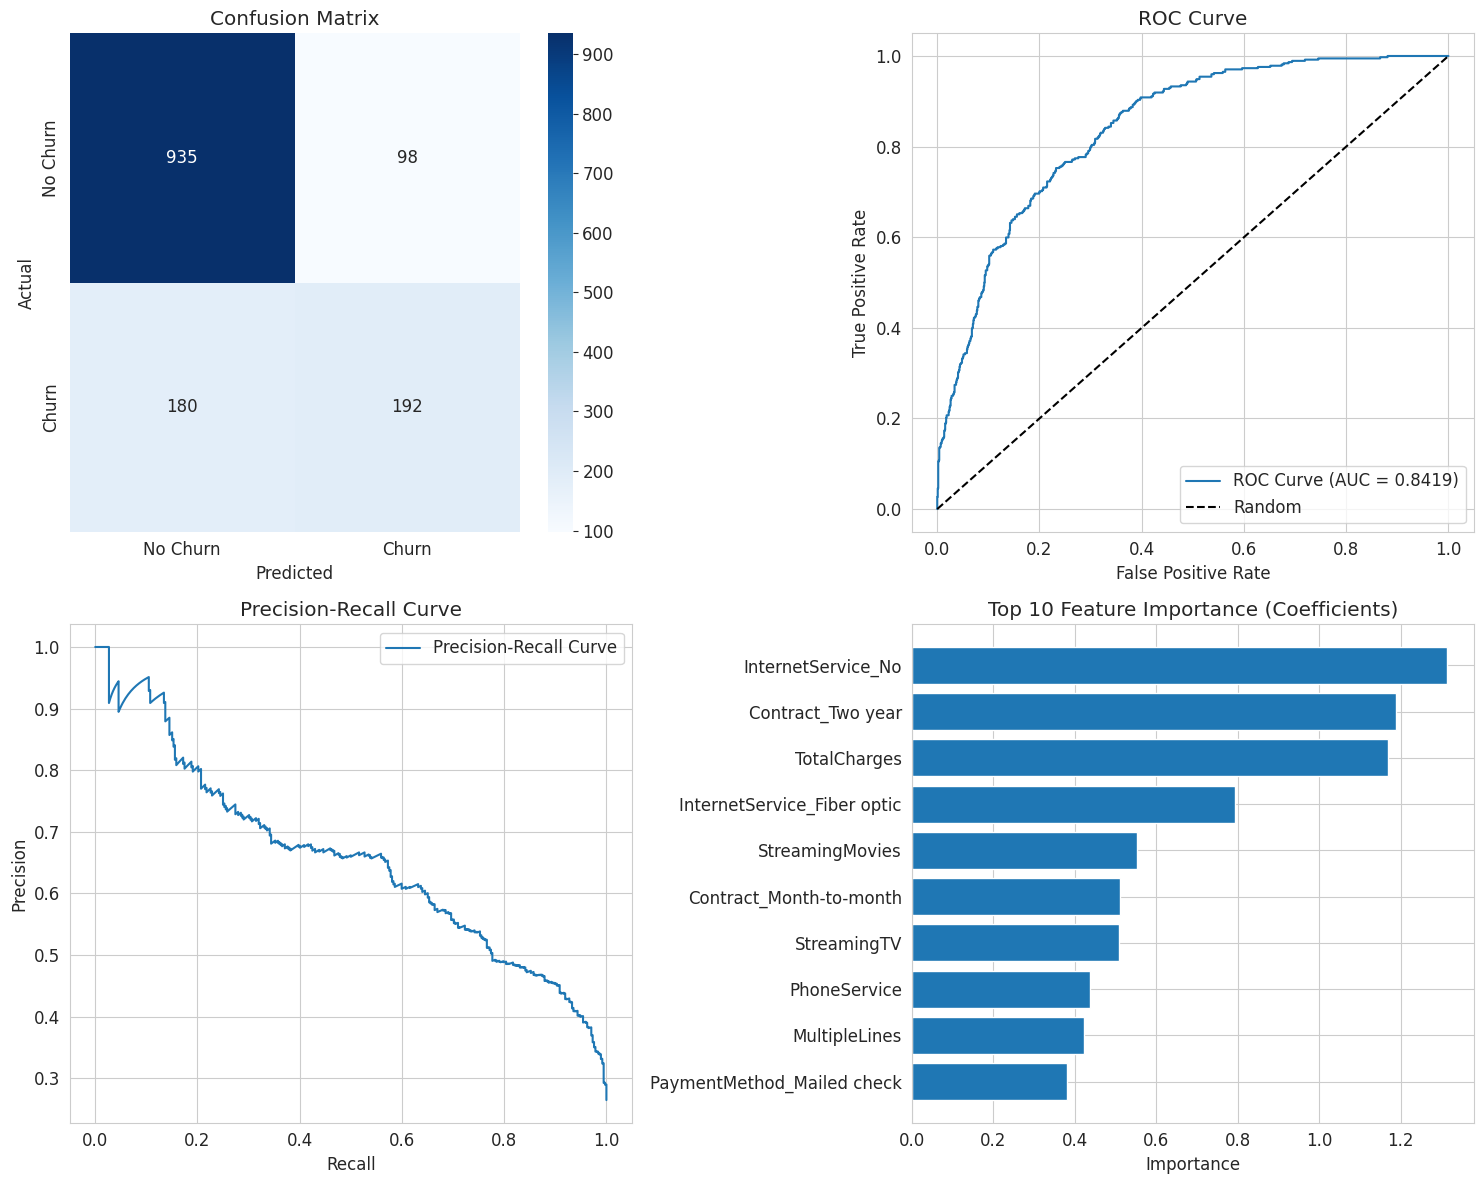

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

metrics = evaluate_classification_model(
    model,
    X_train, y_train,
    X_test, y_test,
    model_name="Logistic Regression",
    class_names=['No Churn', 'Churn'],  # Tên các lớp (tùy chọn),
    feature_names=feature_names
)

### 3. Cải tiến mô hình: sử dụng thêm class_weight = 'balanced'

=== Đánh giá mô hình Logistic Regression ===
Train Accuracy: 0.7585
Test Accuracy: 0.7452
Test Precision: 0.7956
Test Recall: 0.7452
Test F1-Score: 0.7580
Test ROC-AUC: 0.8416

Classification Report (Test):
              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.81      1033
       Churn       0.51      0.77      0.61       372

    accuracy                           0.75      1405
   macro avg       0.71      0.75      0.71      1405
weighted avg       0.80      0.75      0.76      1405



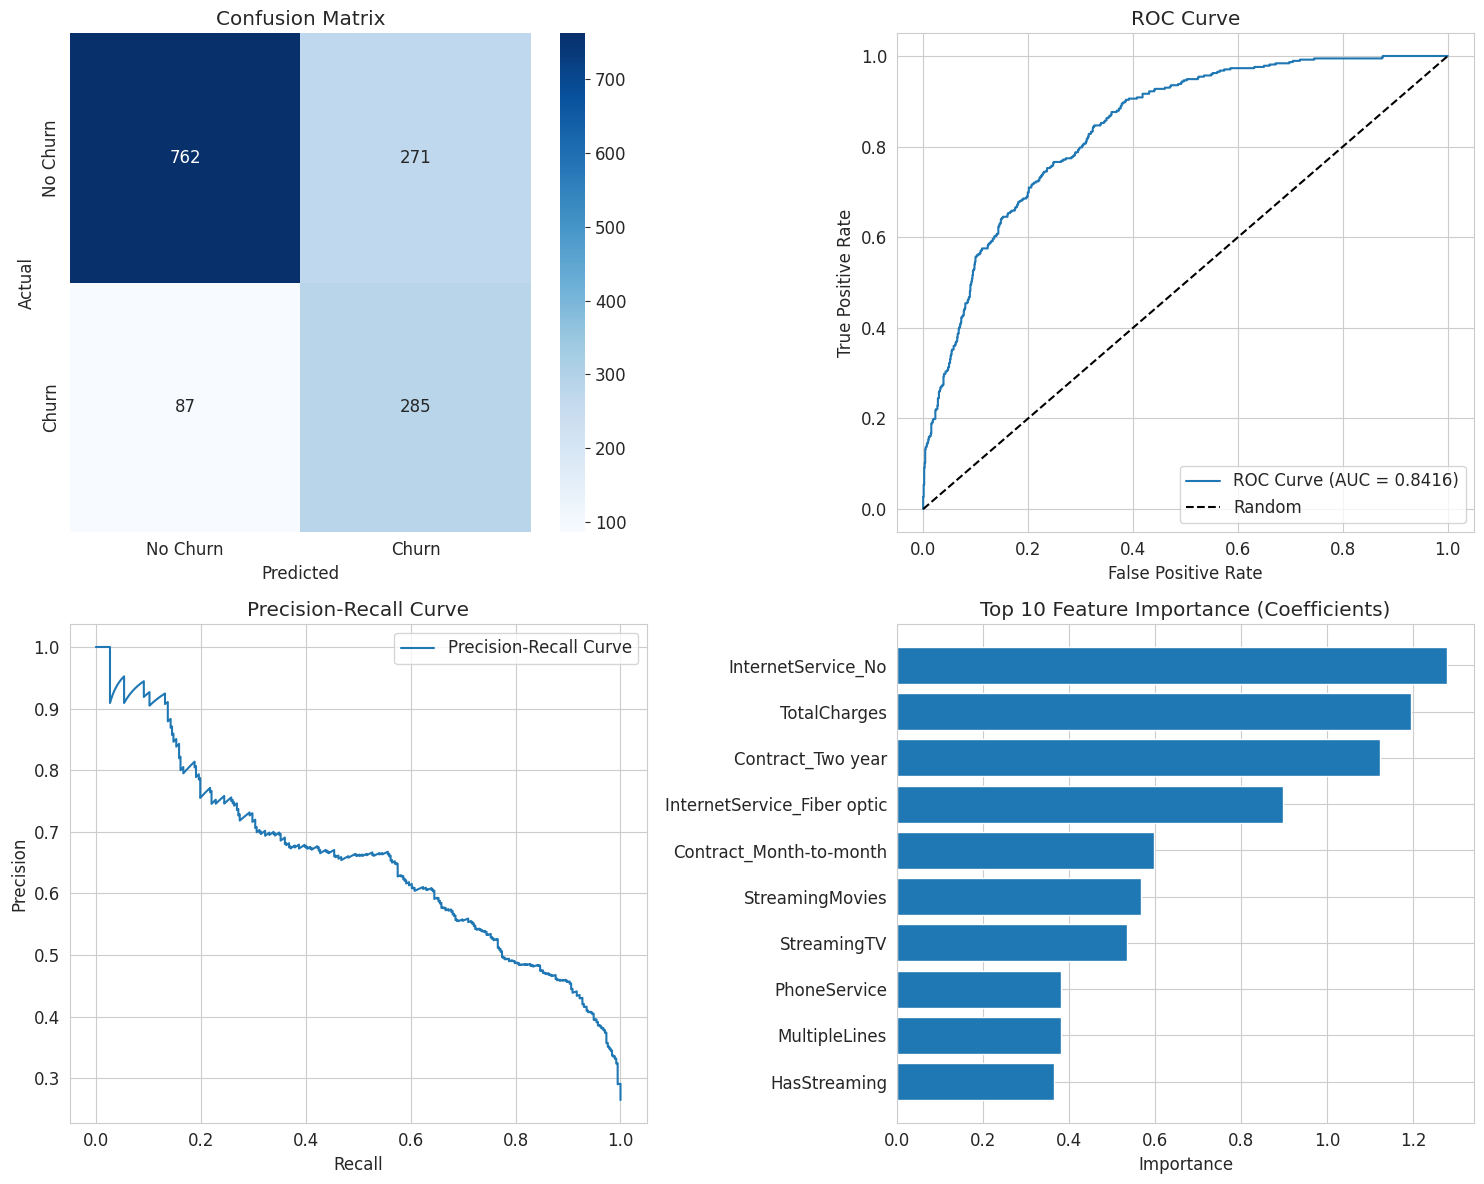

In [ ]:
model = LogisticRegression(random_state=42,class_weight='balanced')
model.fit(X_train, y_train)

metrics = evaluate_classification_model(
    model,
    X_train, y_train,
    X_test, y_test,
    model_name="Logistic Regression",
    class_names=['No Churn', 'Churn'],  # Tên các lớp (tùy chọn),
    feature_names=feature_names
)

### 3. Sử dụng mô hình mạnh mẽ hơn: Random Forest + kỹ thuật xử lý mất cân bằng

=== Đánh giá mô hình Random Forest ===
Train Accuracy: 0.8470
Test Accuracy: 0.7794
Test Precision: 0.8023
Test Recall: 0.7794
Test F1-Score: 0.7868
Test ROC-AUC: 0.8409

Classification Report (Test):
              precision    recall  f1-score   support

    No Churn       0.89      0.80      0.84      1033
       Churn       0.57      0.72      0.63       372

    accuracy                           0.78      1405
   macro avg       0.73      0.76      0.74      1405
weighted avg       0.80      0.78      0.79      1405



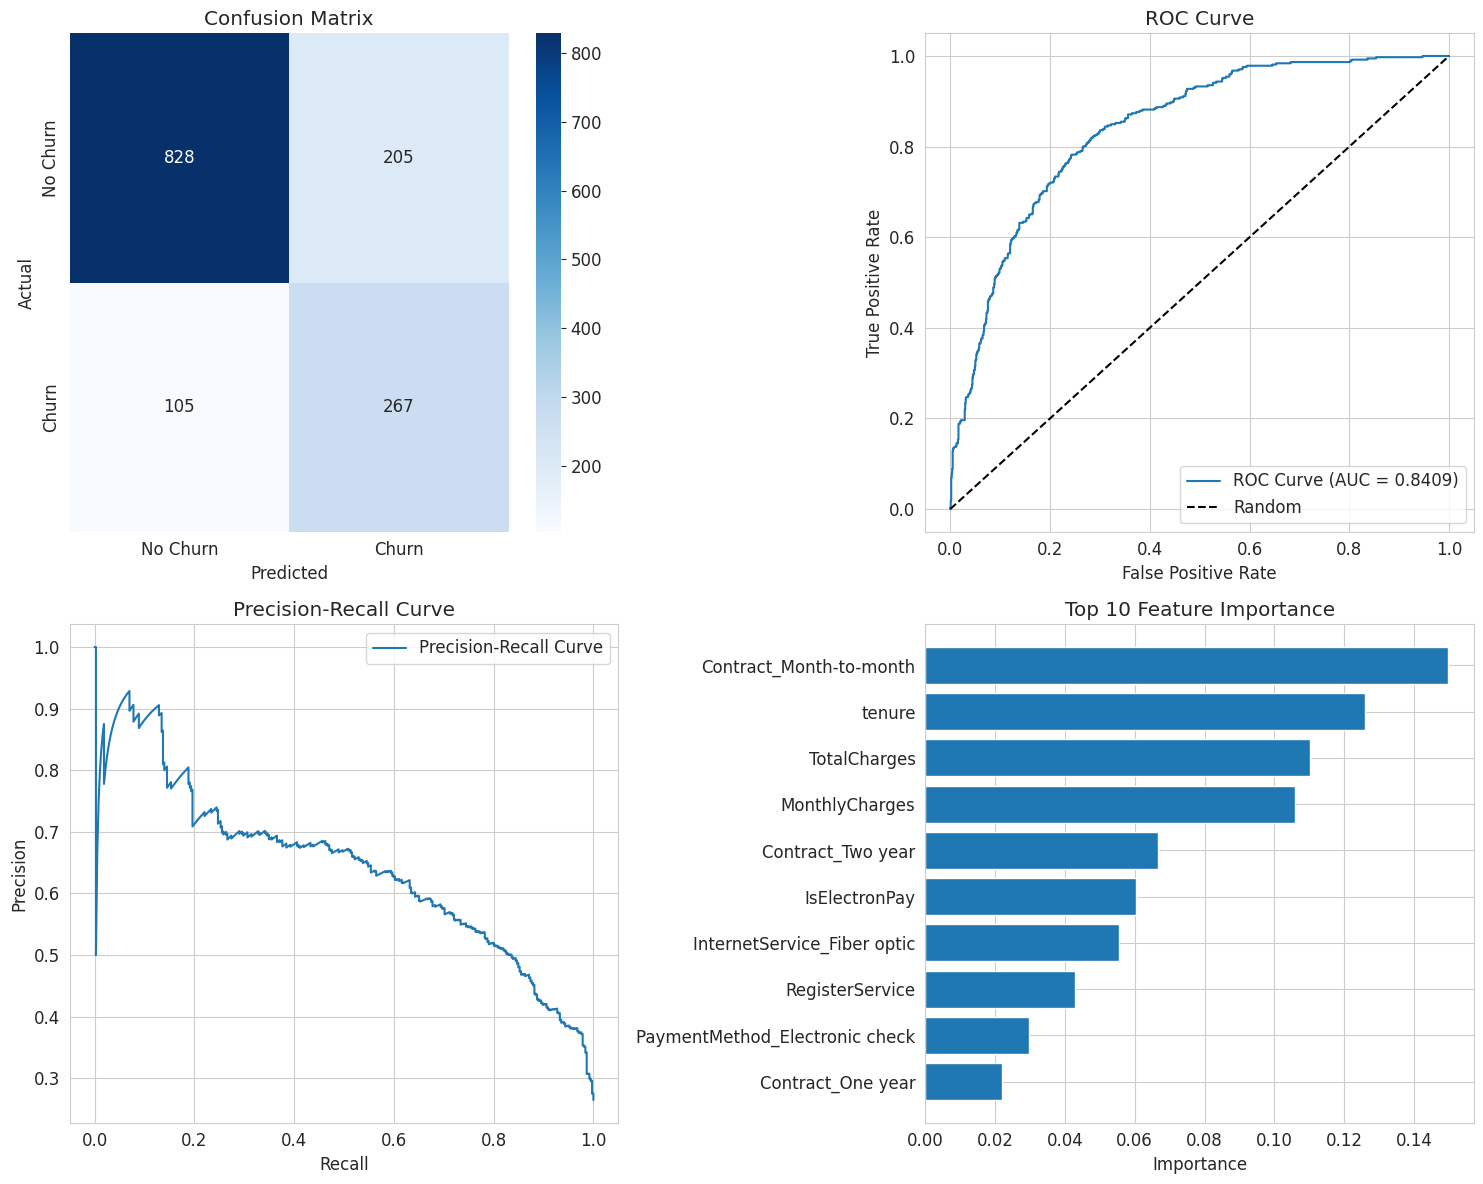

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_balanced.fit(X_train, y_train)

metrics = evaluate_classification_model(
    rf_balanced,
    X_train, y_train,
    X_test, y_test,
    model_name="Random Forest",
    class_names=['No Churn', 'Churn'],  # Tên các lớp (tùy chọn)
    feature_names=feature_names
)

#### 4. Sử dụng LogisticRegressions tối ưu tham số bằng RandomSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
# Định nghĩa không gian tham số cho Random Search
param_distributions = {
    'C': loguniform(1e-4, 1e2),  # Regularization strength (nghịch đảo)
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Loại regularization
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Thuật toán tối ưu
    'max_iter': [100, 200, 500, 1000, 2000],  # Số vòng lặp tối đa
    'class_weight': ['balanced', None],  # Cân bằng class
    'l1_ratio': uniform(0, 1)  # Tỷ lệ L1 (chỉ dùng cho elasticnet)
}

# Khởi tạo Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    n_iter=100,  # Số lượng tổ hợp tham số để thử
    cv=5,  # 5-fold cross validation
    scoring='recall',  # Có thể thay bằng 'f1', 'roc_auc', 'precision', 'recall'
    n_jobs=-1,  # Sử dụng tất cả CPU
    verbose=2,  # Hiển thị tiến trình
    random_state=42,
    return_train_score=True
)

# Fit model với dữ liệu training
print("Bắt đầu Random Search...")
random_search.fit(X_train, y_train)

# Kết quả tốt nhất
print("\n=== KẾT QUẢ TỐI ƯU ===")
print(f"Best Score (CV): {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Lấy model tốt nhất
best_model = random_search.best_estimator_


# Hiển thị top 5 kết quả
print("\n=== TOP 5 COMBINATIONS ===")
results_df = pd.DataFrame(random_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]
for idx, row in top_5.iterrows():
    print(f"\nRank {top_5.index.get_loc(idx) + 1}:")
    print(f"  Mean CV Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")

Bắt đầu Random Search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

=== KẾT QUẢ TỐI ƯU ===
Best Score (CV): 0.8061

Best Parameters:
  C: 0.047314746448150063
  class_weight: balanced
  l1_ratio: 0.05808361216819946
  max_iter: 2000
  penalty: None
  solver: saga

Test Accuracy: 0.7445

=== TOP 5 COMBINATIONS ===

Rank 1:
  Mean CV Score: 0.8061 (+/- 0.0131)
  Params: {'C': np.float64(0.047314746448150063), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.05808361216819946), 'max_iter': 2000, 'penalty': None, 'solver': 'saga'}

Rank 2:
  Mean CV Score: 0.8061 (+/- 0.0131)
  Params: {'C': np.float64(0.1408146893930583), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.13949386065204183), 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}

Rank 3:
  Mean CV Score: 0.8061 (+/- 0.0131)
  Params: {'C': np.float64(0.0009808478272431494), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.9868869366005173), 'max_iter': 100, 'penalty': None, 'solver': 'saga'}




=== ĐÁNH GIÁ MODEL TỐI ƯU ===
=== Đánh giá mô hình Optimized Logistic Regression ===
Train Accuracy: 0.7575
Test Accuracy: 0.7445
Test Precision: 0.7960
Test Recall: 0.7445
Test F1-Score: 0.7574
Test ROC-AUC: 0.8411

Classification Report (Test):
              precision    recall  f1-score   support

     Class 0       0.90      0.74      0.81      1033
     Class 1       0.51      0.77      0.61       372

    accuracy                           0.74      1405
   macro avg       0.70      0.75      0.71      1405
weighted avg       0.80      0.74      0.76      1405



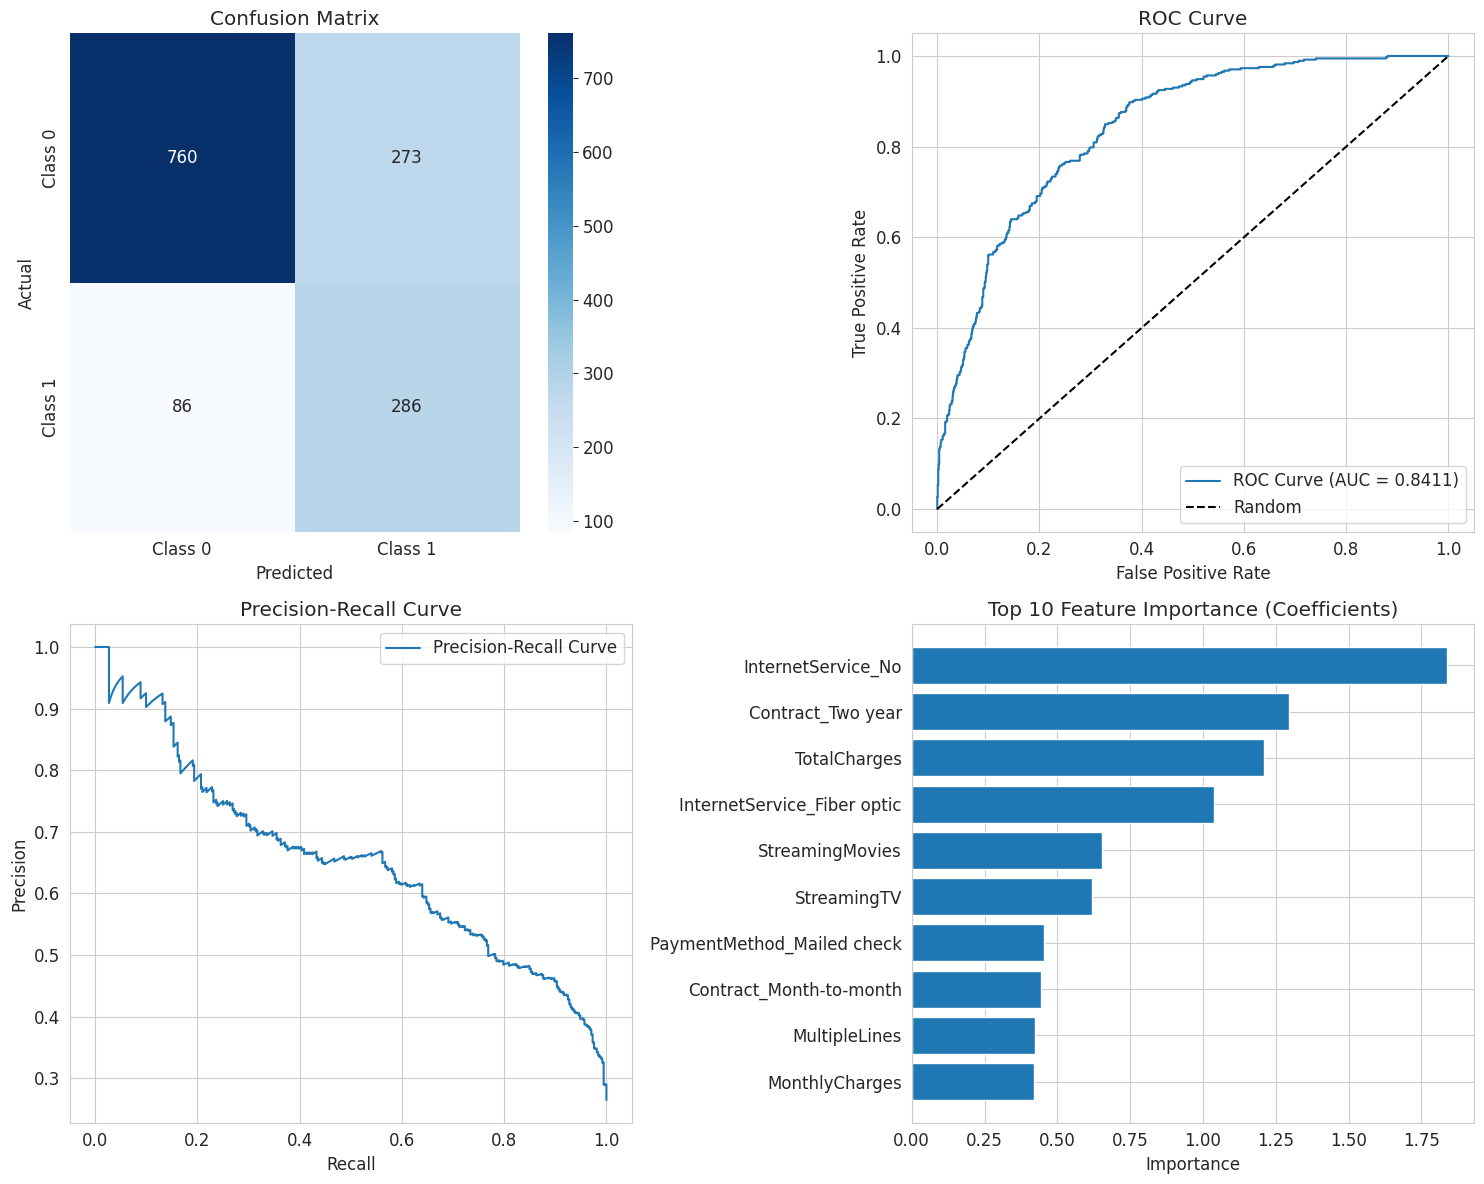

In [ ]:
# Sử dụng model tốt nhất để đánh giá
print("\n=== ĐÁNH GIÁ MODEL TỐI ƯU ===")
if 'evaluate_classification_model' in dir():
    metrics = evaluate_classification_model(
        model=best_model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_name="Optimized Logistic Regression",
        class_names=['Class 0', 'Class 1'],
        feature_names=X_train.columns.tolist() if hasattr(X_train, 'columns') else None
    )

### 5. Sử dụng XGBoost tối ưu siêu tham số

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Định nghĩa không gian siêu tham số cho XGBoost
param_distributions = {
    # Boosting parameters
    'n_estimators': randint(50, 500),  # Số lượng cây
    'learning_rate': uniform(0.01, 0.3),  # Tốc độ học (eta)
    'max_depth': randint(3, 10),  # Độ sâu tối đa của cây

    # Tree-specific parameters
    'min_child_weight': randint(1, 10),  # Trọng số tối thiểu của node con
    'subsample': uniform(0.6, 0.4),  # Tỷ lệ mẫu con (0.6 - 1.0)
    'colsample_bytree': uniform(0.6, 0.4),  # Tỷ lệ features cho mỗi cây
    'colsample_bylevel': uniform(0.6, 0.4),  # Tỷ lệ features cho mỗi level
    'colsample_bynode': uniform(0.6, 0.4),  # Tỷ lệ features cho mỗi split

    # Regularization parameters
    'gamma': uniform(0, 0.5),  # Giảm phức tạp (min split loss)
    'reg_alpha': uniform(0, 1),  # L1 regularization
    'reg_lambda': uniform(0, 2),  # L2 regularization

    # Other parameters
    'scale_pos_weight': uniform(1, 3),  # Cân bằng class (cho imbalanced data)
}

# Khởi tạo XGBoost Classifier
xgb_model = XGBClassifier(
    random_state=42,
    n_jobs=-1,  # Sử dụng tất cả CPU
    tree_method='hist',  # Thuật toán xây dựng cây nhanh hơn
    eval_metric='logloss'  # Metric để đánh giá
)

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # Số lượng tổ hợp tham số để thử
    cv=5,  # 5-fold cross validation
    scoring='f1',  # Có thể thay: 'f1', 'roc_auc', 'precision', 'recall'
    n_jobs=-1,  # Sử dụng tất cả CPU
    verbose=2,  # Hiển thị tiến trình
    random_state=42,
    return_train_score=True
)

# Fit model với dữ liệu training
print("Bắt đầu Random Search cho XGBoost...")
print("Đây có thể mất vài phút...\n")
random_search.fit(X_train, y_train)

Bắt đầu Random Search cho XGBoost...
Đây có thể mất vài phút...

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79d0f4808c50>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79d0f43ce900>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79d0f41d68d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79d0f4245040>},
                   random_state=42, return_train_score=True, scoring='f1',
                   verbose=2)

In [ ]:
# Kết quả tốt nhất
print("\n" + "="*60)
print("=== KẾT QUẢ TỐI ƯU ===")
print("="*60)
print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in sorted(random_search.best_params_.items()):
    if isinstance(value, float):
        print(f"  {param:25s}: {value:.4f}")
    else:
        print(f"  {param:25s}: {value}")

# Lấy model tốt nhất
best_model = random_search.best_estimator_


=== KẾT QUẢ TỐI ƯU ===
Best Cross-Validation Score: 0.6336

Best Parameters:
  colsample_bylevel        : 0.6053
  colsample_bynode         : 0.9769
  colsample_bytree         : 0.8253
  gamma                    : 0.1927
  learning_rate            : 0.0148
  max_depth                : 4
  min_child_weight         : 4
  n_estimators             : 141
  reg_alpha                : 0.4402
  reg_lambda               : 0.2441
  scale_pos_weight         : 2.4855
  subsample                : 0.6138


=== ĐÁNH GIÁ CHI TIẾT MODEL TỐI ƯU ===
=== Đánh giá mô hình Optimized XGBoost ===
Train Accuracy: 0.7721
Test Accuracy: 0.7587
Test Precision: 0.8014
Test Recall: 0.7587
Test F1-Score: 0.7701
Test ROC-AUC: 0.8423

Classification Report (Test):
              precision    recall  f1-score   support

     Class 0       0.90      0.76      0.82      1033
     Class 1       0.53      0.76      0.63       372

    accuracy                           0.76      1405
   macro avg       0.71      0.76      0.72      1405
weighted avg       0.80      0.76      0.77      1405



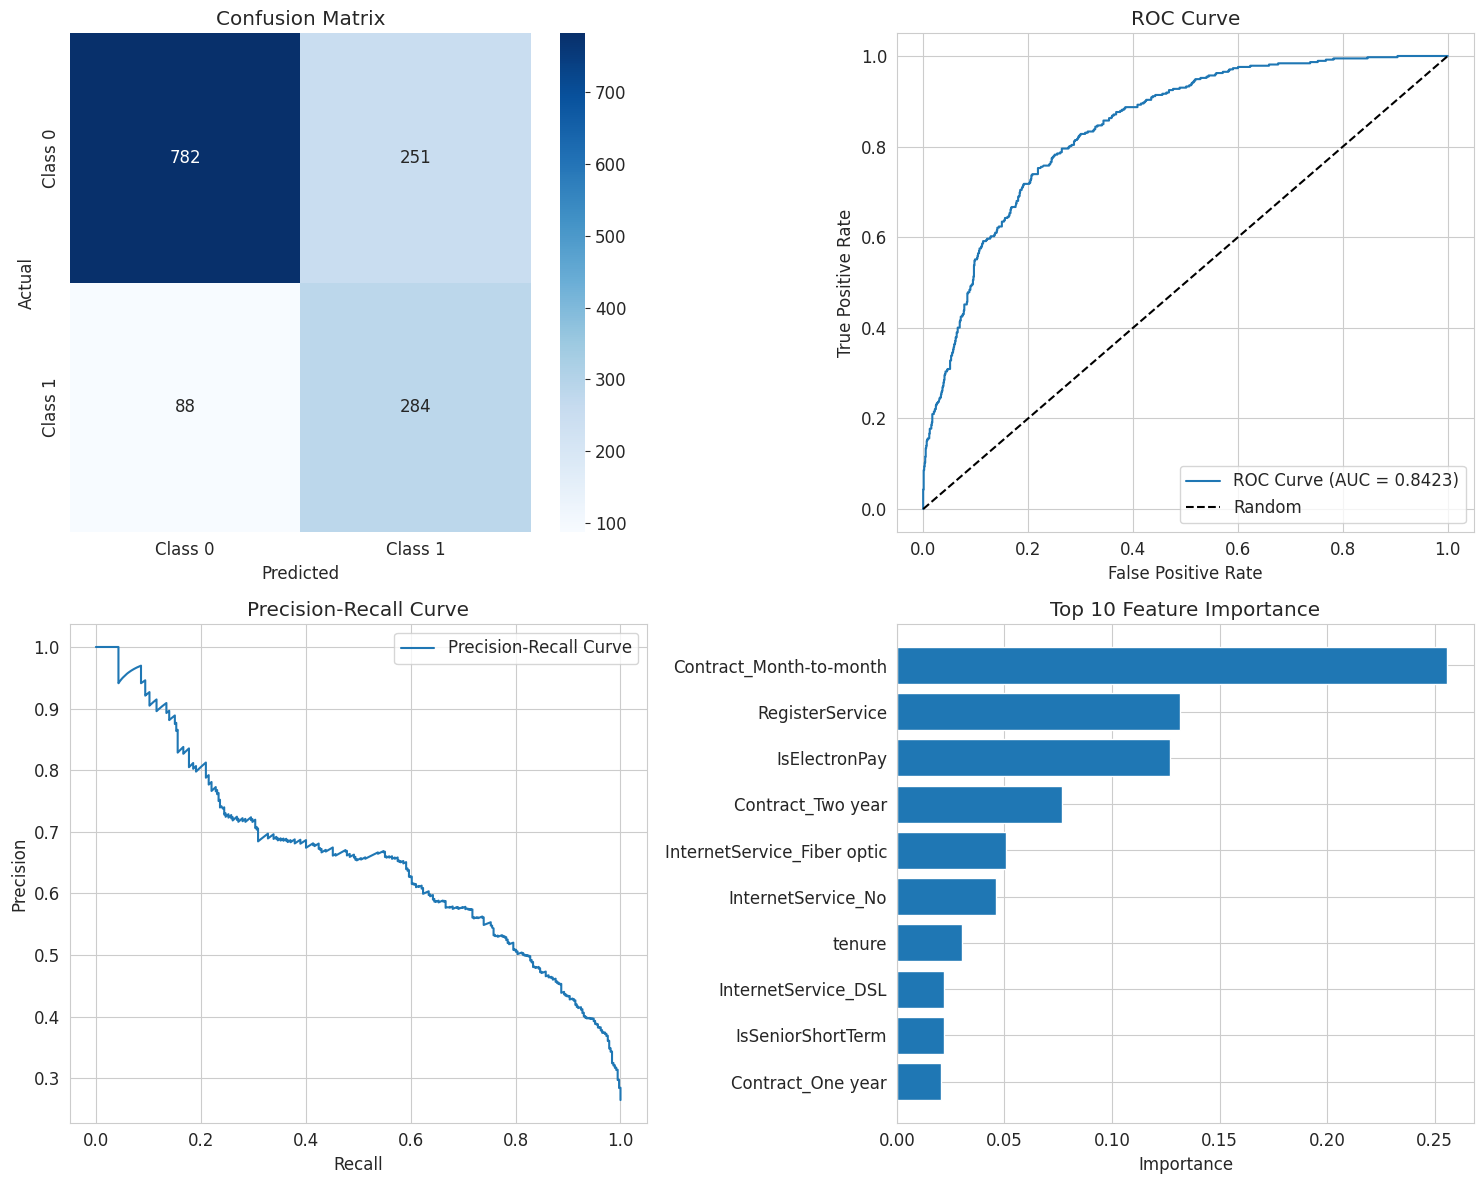

In [ ]:
print("=== ĐÁNH GIÁ CHI TIẾT MODEL TỐI ƯU ===")
print("="*60)
metrics = evaluate_classification_model(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Optimized XGBoost",
    class_names=['Class 0', 'Class 1'],
    feature_names=feature_names
)

#### 6. Sử dụng LightGBM tối ưu siêu tham số

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# Định nghĩa không gian siêu tham số cho LightGBM
param_distributions = {
    # Boosting parameters
    'n_estimators': randint(100, 1000),  # Số lượng cây
    'learning_rate': uniform(0.01, 0.3),  # Tốc độ học
    'num_leaves': randint(20, 150),  # Số lá tối đa (quan trọng cho LightGBM)
    'max_depth': randint(-1, 50),  # -1 = no limit

    # Tree structure
    'min_child_samples': randint(5, 100),  # Số mẫu tối thiểu ở leaf
    'min_child_weight': uniform(1e-3, 10),  # Trọng số tối thiểu
    'min_split_gain': uniform(0.0, 1.0),  # Gain tối thiểu để split

    # Sampling
    'subsample': uniform(0.5, 0.5),  # Tỷ lệ mẫu (0.5-1.0)
    'subsample_freq': randint(0, 10),  # Tần suất subsample
    'colsample_bytree': uniform(0.5, 0.5),  # Tỷ lệ features (0.5-1.0)

    # Regularization
    'reg_alpha': uniform(0.0, 1.0),  # L1 regularization
    'reg_lambda': uniform(0.0, 1.0),  # L2 regularization

    # Other parameters
    'max_bin': randint(128, 512),  # Số bins cho histogram
    'boosting_type': ['gbdt', 'dart', 'goss'],  # Loại boosting
}

# Khởi tạo LightGBM Classifier
lgbm_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1,  # Sử dụng tất cả CPU
    verbose=-1,  # Tắt warning
    force_col_wise=True  # Tối ưu cho dataset nhiều features
)

# Khởi tạo RandomizedSearchCV với F1-Score
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=100,  # Số lượng tổ hợp tham số để thử
    cv=5,  # 5-fold cross validation
    scoring="f1",  # Tối ưu F1-Score
    n_jobs=-1,  # Sử dụng tất cả CPU
    verbose=2,  # Hiển thị tiến trình
    random_state=42,
    return_train_score=True
)

In [266]:
# Fit model với dữ liệu training
print("="*70)
print("Bắt đầu Random Search cho LightGBM (tối ưu F1-Score)...")
print("Đây có thể mất vài phút...")
print("="*70 + "\n")
random_search.fit(X_train, y_train)

# Kết quả tốt nhất
print("\n" + "="*70)
print("=== KẾT QUẢ TỐI ƯU (F1-SCORE) ===")
print("="*70)
print(f"Best Cross-Validation F1-Score: {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in sorted(random_search.best_params_.items()):
    if isinstance(value, float):
        print(f"  {param:25s}: {value:.4f}")
    else:
        print(f"  {param:25s}: {value}")

# Lấy model tốt nhất
best_model = random_search.best_estimator_

Bắt đầu Random Search cho LightGBM (tối ưu F1-Score)...
Đây có thể mất vài phút...

Fitting 5 folds for each of 100 candidates, totalling 500 fits

=== KẾT QUẢ TỐI ƯU (F1-SCORE) ===
Best Cross-Validation F1-Score: 0.5932

Best Parameters:
  boosting_type            : gbdt
  colsample_bytree         : 0.5318
  learning_rate            : 0.0210
  max_bin                  : 438
  max_depth                : 4
  min_child_samples        : 96
  min_child_weight         : 8.1300
  min_split_gain           : 0.9997
  n_estimators             : 969
  num_leaves               : 22
  reg_alpha                : 0.5554
  reg_lambda               : 0.7690
  subsample                : 0.9724
  subsample_freq           : 9


=== Đánh giá mô hình Optimized LightGBM (F1-Score) ===
Train Accuracy: 0.8216
Test Accuracy: 0.7986
Test Precision: 0.7887
Test Recall: 0.7986
Test F1-Score: 0.7911
Test ROC-AUC: 0.8433

Classification Report (Test):
              precision    recall  f1-score   support

     Class 0       0.84      0.90      0.87      1033
     Class 1       0.65      0.52      0.58       372

    accuracy                           0.80      1405
   macro avg       0.74      0.71      0.72      1405
weighted avg       0.79      0.80      0.79      1405



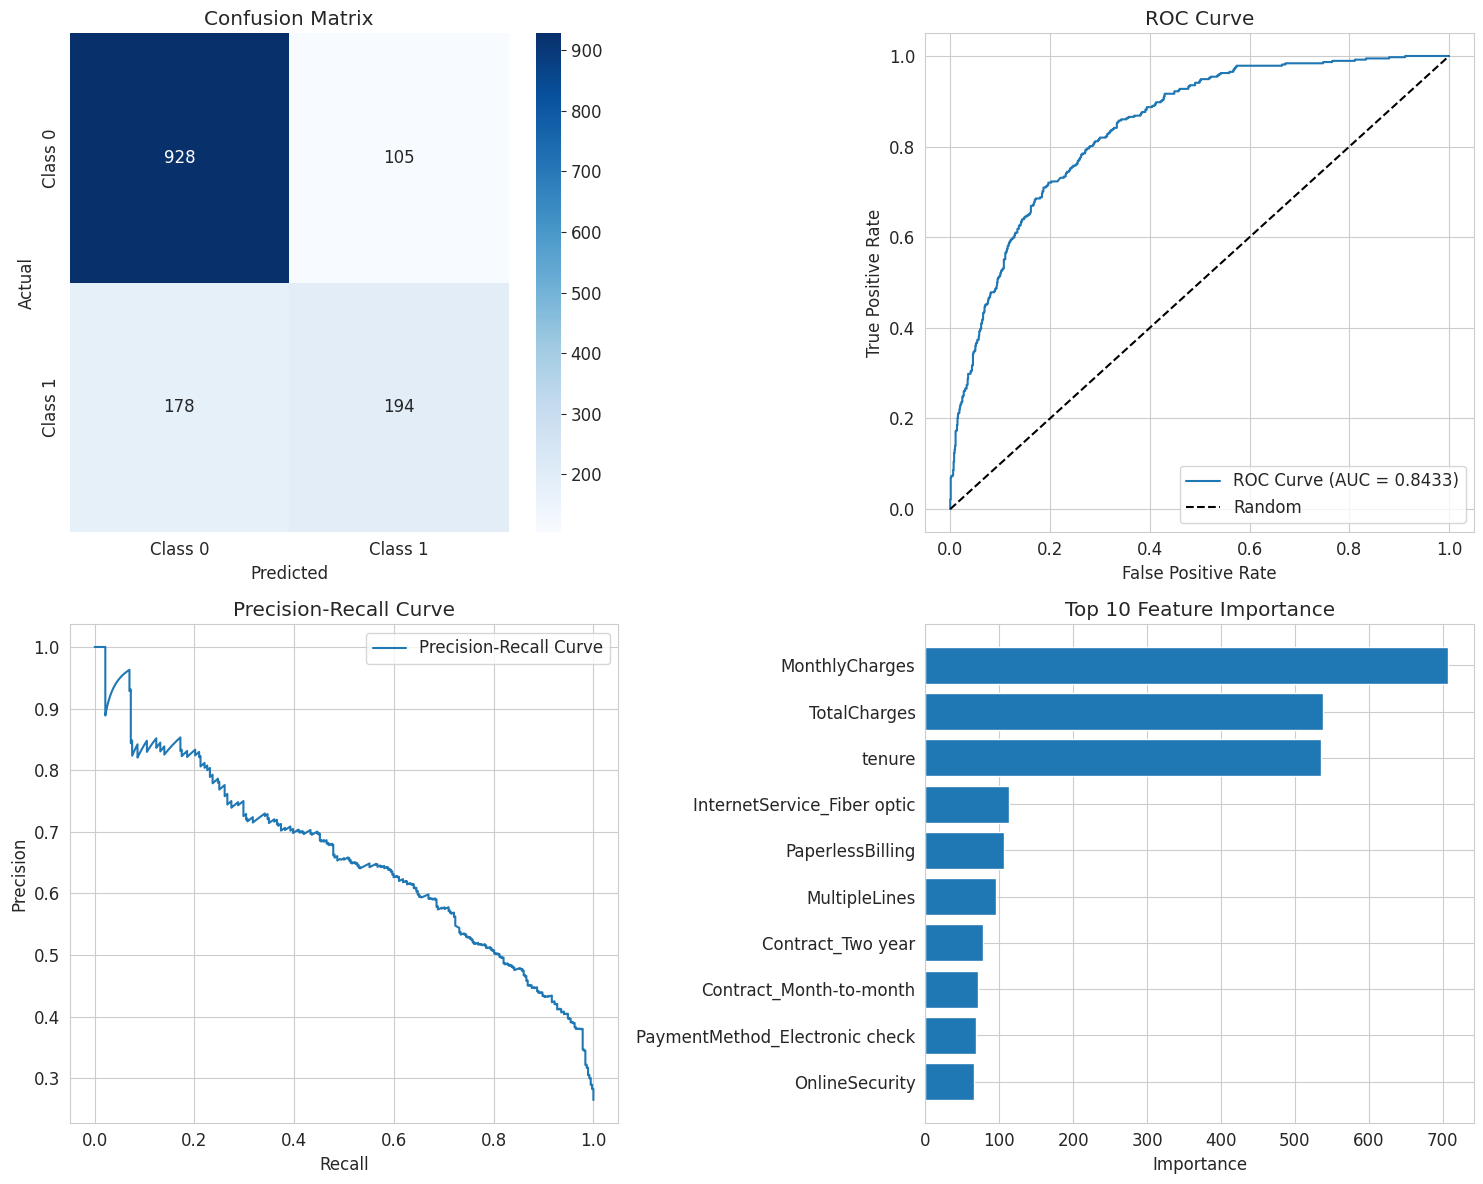

In [267]:
metrics = evaluate_classification_model(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Optimized LightGBM (F1-Score)",
    class_names=['Class 0', 'Class 1'],  # Thay đổi tùy theo dataset
    feature_names=feature_names
)